<div style="
    background: rgba(25, 25, 25, 0.55);
    backdrop-filter: blur(16px) saturate(150%);
    -webkit-backdrop-filter: blur(16px) saturate(150%);
    border: 1px solid rgba(255, 255, 255, 0.12);
    border-radius: 18px;
    padding: 45px 30px;
    text-align: center;
    font-family: 'Inter', 'Segoe UI', 'Helvetica Neue', Arial, sans-serif;
    color: #e0e0e0;
    box-shadow: 0 0 30px rgba(0, 0, 0, 0.35);
    margin: 40px auto;
    max-width: 800px;
">

  <h1 style="
      font-size: 2.8em;
      font-weight: 700;
      margin: 0 0 8px 0;
      letter-spacing: -0.02em;
      background: linear-gradient(90deg, #00e0ff, #9c7eff);
      -webkit-background-clip: text;
      -webkit-text-fill-color: transparent;
  ">
      Machine Learning Project
  </h1>

  <h2 style="
      font-size: 1.6em;
      font-weight: 500;
      margin: 0 0 25px 0;
      color: #b0b0b0;
      letter-spacing: 0.5px;
  ">
      Cars price prediction
  </h2>

  <p style="
      font-size: 1.25em;
      font-weight: 500;
      color: #c0c0c0;
      margin-bottom: 6px;
  ">
      Group 5
  </p>

  <p style="
      font-size: 1.05em;
      font-weight: 400;
      color: #8a8a8a;
      font-style: italic;
      letter-spacing: 0.5px;
  ">
      Machine Learning Part 1 · 2025 / 2026
  </p>
</div>


# **Table of Contents**

- [1. Import & Load Data]()  
- [2. Basic Overview]()  
- [3. Separation of Numerical and Categorical Features]()  
- [4. Univariate Analysis]()  
  - [4.1 Numerical]()  
  - [4.2 Categorical]()  
  - [4.3 Findings after Descriptive Statistics and Inconsistency Check]()  
- [5. Univariate After Data Cleaning]()  
  - [5.1 Numerical]()  
  - [5.2 Categorical]()  
  - [5.3 New Findings After Cleaning]()  
- [6. Bivariate Analysis]()  
  - [6.1 Numerical–Numerical Associations]()  
    - [6.1.1 Pairplot]()  
    - [6.1.2 Correlation]()  
  - [6.2 Numerical–Categorical Associations]()  
  - [6.3 Categorical–Categorical Associations]()  
    - [6.3.1 Stacked Bar Charts]()  
    - [6.3.2 Cramér’s V]()  
- [7. Multivariate Analysis]()  
  - [7.1 Price vs. Year vs. EngineSize]()  
  - [7.2 EngineSize vs. MPG vs. Price]()


Cars 4 You is an online car resale company that sells cars from multiple different brands.  
Their main goal is to expedite the evaluation process by creating a predictive model capable of evaluating the price of a car based on the user’s input without needing the car to be taken to a mechanic.

| **Attribute**       | **Description** |
|----------------------|-----------------|
| **carID**            | An attribute that contains an identifier for each car. |
| **Brand**            | The car’s main brand (e.g. Ford, Toyota) |
| **model**            | The car model |
| **year**             | The year of Registration of the Car |
| **mileage**          | The total reported distance travelled by the car (in miles) |
| **tax**              | The amount of road tax (in £) that, in 2020, was applicable to the car in question. |
| **fuelType**         | Type of Fuel used by the car (Diesel, Petrol, Hybrid, Electric) |
| **mpg**              | Average Miles per Gallon (fuel efficiency) |
| **engineSize**       | Size of engine in liters (cubic decimeters) |
| **paintQuality%**    | The mechanic’s assessment of the cars’ overall paint quality and hull integrity (filled by the mechanic during evaluation). |
| **previousOwners**   | Number of previous registered owners of the vehicle |
| **hasDamage**        | Boolean marker filled by the seller at the time of registration stating whether the car is damaged or not |
| **price (TARGET)**            | The car’s price when purchased by Cars 4 You (in £) |

# 1. Import & load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import joblib
import seaborn as sns
from pipeline_functions import CarDataCleaner
from itertools import combinations
from scipy.stats import chi2_contingency

In [2]:
df_cars_train = pd.read_csv("train.csv")
df_cars_test = pd.read_csv("test.csv")

# 2. Basic Overview

In [3]:
# Overview of structure and data types
df_cars_train.info()

# Strip whitespace and lowercase before duplicate check
df_cars_train = df_cars_train.replace(r'^\s*$', np.nan, regex=True)

# Check for duplicates
print(f"\nDuplicate rows: {df_cars_train.duplicated().sum()}") # 0

# Check for duplicate carID
print(f"\nDuplicate carID: {df_cars_train['carID'].duplicated().sum()}") # 0
print(f"Null values in column carID: {df_cars_train['carID'].isnull().sum()}") # 0
print(f"All carID entries are unique: {df_cars_train['carID'].nunique()}/{len(df_cars_train)}")


# Findings:
#   - missing values in every column except carID and price
#   - year, mpg, previousOwners, hasDamage as float seems weird
#   - no duplicates in all columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB

Duplicate rows: 0

Duplicate carID: 0
Null values in column carID: 0
All carID entries are unique: 75973/759

In [4]:
# Missing-value rate per column (0–1), sorted descending
print(df_cars_train.isna().mean().sort_values(ascending=False).to_string())

mpg               0.104327
tax               0.104037
previousOwners    0.020402
hasDamage         0.020376
paintQuality%     0.020060
transmission      0.020033
Brand             0.020020
model             0.019968
engineSize        0.019954
fuelType          0.019889
year              0.019625
mileage           0.019257
carID             0.000000
price             0.000000


In [5]:
display(df_cars_train.describe().T)
display(df_cars_train.describe(include="object").T)

### First Findings (extensive description of each attribute in Univariate Section):
# Numerical:
#   - carID is unique identifier
#   - years range from 1970 to 2024.12 (a float so maybe some have month info?) with most of the cars being between 2016 and 2019 (max value of 2024 doesnt make sense because database is from 2020)
#   - price ranges from 450 to 159.999 with mean ~17.000, median ~14.500 and std ~10.000 -> right skewed distribution (some cars with high prices)
#   - mileage ranges from a negative value (probably wrong data entry) to 323.000 with mean ~23.000, median 17300 and std ~22.000 -> right skewed distribution (some cars with very high mileage) and high variance
#   - tax ranges from a negative value (probably wrong data entry) to 580 with mean ~120, median 145 and std ~65 -> left skewed distribution (some cars with low tax)
#   - mpg ranges from a negative value (probably wrong data entry) to 470,8 with mean ~55, median 54,3 and std ~16 -> not skewed
#   - engineSize ranges from a negative value (probably wrong data entry) to 6,6 with mean ~1,6 median 1.6 and std ~0,5 -> not skewed
#   - paintQuality% ranges from 1,6 to 125,6 (should be 0-100% -> probably wrong data entry) with mean ~65, median 28,7 and std ~12 -> not skewed
#   - previousOwners ranges from a negative value (probably wrong data entry) to 6,3 (shouldnt be float values -> probably wrong data entry) with mean ~2 median 2 and std ~1,5 -> not skewed but high variance
#   - hasDamage is only 0 values -> probably wrong data entries
# Categorical:
#   - 72 unique brands (though multpiple wrong data entries result in less unique brands (see EDA below))
#   - 735 unique models
#   - transmission with 40 unique values -> probably wrong data entries because it should be somewhat limited to manual and automatic
#   - fuelType with 34 unique values -> probably wrong data entries because it should be limited to petrol, diesel, electric, hybrid

count          mean           std           min       25%  \
carID           75973.0  37986.000000  21931.660338      0.000000  18993.00   
year            74482.0   2017.096611      2.208704   1970.000000   2016.00   
price           75973.0  16881.889553   9736.926322    450.000000  10200.00   
mileage         74510.0  23004.184088  22129.788366 -58540.574478   7423.25   
tax             68069.0    120.329078     65.521176    -91.121630    125.00   
mpg             68047.0     55.152666     16.497837    -43.421768     46.30   
engineSize      74457.0      1.660136      0.573462     -0.103493      1.20   
paintQuality%   74449.0     64.590667     21.021065      1.638913     47.00   
previousOwners  74423.0      1.994580      1.472981     -2.345650      1.00   
hasDamage       74425.0      0.000000      0.000000      0.000000      0.00   

                    50%      75%            max  
carID           37986.0  56979.0   75972.000000  
year             2017.0   2019.0    2024.121759  
price           14699.0  20950.0  159999.000000  
mileage         17300.0  32427.5  323000.000000  
tax               145.0    145.0     580.000000  
mpg                54.3     62.8     470.800000  
engineSize          1.6      2.0       6.600000  
paintQuality%      65.0     82.0     125.594308  
previousOwners      2.0      3.0       6.258371  
hasDamage           0.0      0.0       0.000000

count unique     top   freq
Brand         74452     72    Ford  14808
model         74456    735   Focus   6353
transmission  74451     40  Manual  38050
fuelType      74462     34  Petrol  37995

In [6]:
# print exact unique values of df_cars_train to identify wrong data entries
for col in df_cars_train.columns:
    print(col, df_cars_train[col].unique())

carID [69512 53000  6366 ... 54886   860 15795]
Brand ['VW' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes' 'FOR'
 'mercedes' 'Hyundai' 'w' 'ord' 'MW' 'bmw' nan 'yundai' 'BM' 'Toyot' 'udi'
 'Ope' 'AUDI' 'V' 'opel' 'pel' 'For' 'pe' 'Mercede' 'audi' 'MERCEDES'
 'OPEL' 'koda' 'FORD' 'Hyunda' 'W' 'Aud' 'vw' 'hyundai' 'skoda' 'ford'
 'TOYOTA' 'ercedes' 'oyota' 'toyota' 'SKODA' 'Skod' 'HYUNDAI' 'kod' 'v'
 'for' 'SKOD' 'aud' 'KODA' 'PEL' 'yunda' 'or' 'UDI' 'OYOTA' 'HYUNDA' 'mw'
 'OPE' 'mercede' 'ERCEDES' 'ercede' 'TOYOT' 'MERCEDE' 'ORD' 'ud' 'ope'
 'AUD' 'hyunda' 'skod' 'toyot']
model [' Golf' ' Yaris' ' Q2' ' FIESTA' ' 2 Series' '3 Series' ' A3' ' Octavia'
 ' Passat' ' Focus' ' Insignia' ' A Clas' ' Q3' ' Fabia' ' A Class' ' Ka+'
 ' 3 Series' ' GLC Class' ' I30' ' C Class' ' Polo' ' E Class' ' C Clas'
 ' Q5' ' Up' ' Fiesta' ' C-HR' ' Mokka X' ' Corsa' ' Astra' ' TT'
 ' 5 Series' ' Aygo' ' 4 Series' ' SLK' ' Viva' ' T-Roc' 'Focus'
 ' EcoSport' ' Tucson' ' EcoSpor' nan ' X-CLASS' ' CL C

# 3. Separation of numerical and categorical features

In [7]:
# Standardize categorical variables (strip whitespace, lowercase)
df_cars_train.rename(columns={'Brand': 'brand'}, inplace=True)
cat_cols = [col for col in df_cars_train.columns if df_cars_train[col].dtype == 'object']
print("Categorical columns:", cat_cols)
for col in cat_cols:
    df_cars_train[col] = df_cars_train[col].str.strip().str.lower()

Categorical columns: ['brand', 'model', 'transmission', 'fuelType']


In [8]:
num_cols = [col for col in df_cars_train.columns if df_cars_train[col].dtype in ['int64', 'float64']]
num_cols.remove('carID') # remove carID because its an identifier
num_cols.remove('hasDamage') # remove hasDamage because its only 0 or nan values and even when imputing nan to 1 it has no correlatin with price
df_cars_train['hasDamage'].value_counts(dropna=False)
damaged_to_1 = df_cars_train['hasDamage'].fillna(1).astype('int64')
damaged_to_1.value_counts(dropna=False)
hasDamage_price_corr = damaged_to_1.corr(df_cars_train['price']).round(4)
 
print(f"hasDamage with filled NaN to 1 correlation with price ({hasDamage_price_corr}) is ~0 so its not worth it to make the assumption that NaN means damaged => The feature will be ignored.")
 
print("Numerical columns:", num_cols)

hasDamage with filled NaN to 1 correlation with price (-0.0009) is ~0 so its not worth it to make the assumption that NaN means damaged => The feature will be ignored.
Numerical columns: ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners']


In [9]:
neither_categorical_numerical = [col for col in df_cars_train.columns if col not in cat_cols + num_cols]
neither_categorical_numerical.remove('carID')
neither_categorical_numerical.remove('hasDamage')
print("Neither categorical nor numerical columns:", neither_categorical_numerical)

Neither categorical nor numerical columns: []


# 4. Univariate Analysis

In [10]:
# Visualization settings
sns.set(style="whitegrid")
hist_color = '#1f77b4'   # dark blue
box_color = '#ff7f0e'    # warm orange

## 4.1 Numerical

In [11]:
def plot_numerical_univariate_distributions(df, cols):
    # figure: 2 features per row (4 plots per row = hist + boxplot per feature)
    n_features = len(cols)
    n_rows = int(np.ceil(n_features / 2))
    fig, axes = plt.subplots(n_rows, 4, figsize=(16, n_rows * 4))
    axes = axes.flatten()
    
    for i, col in enumerate(cols):
        # histogram
        sns.histplot(df[col], bins=25, color=hist_color, kde=False, ax=axes[i*2])
        axes[i*2].set_xlabel('')
        axes[i*2].set_ylabel('')
        axes[i*2].set_title(f'{col}', fontsize=11, pad=12)

        if df[col].dtype in ['int64', 'float64', 'Int64', 'Float64']:
            # add mean and median lines
            mean_val = df[col].mean()
            median_val = df[col].median()
            axes[i*2].axvline(mean_val, color='red', linestyle='--', label='Mean')
            axes[i*2].axvline(median_val, color='green', linestyle='-', label='Median')
            axes[i*2].legend()

            # boxplot (vertical)
            sns.boxplot(y=df[col], ax=axes[i*2 + 1], color=box_color)
            axes[i*2 + 1].set_xlabel('')
            axes[i*2 + 1].set_ylabel('')
            axes[i*2 + 1].set_title(f'{col}', fontsize=11, pad=12)

    # hide any unused axes
    for j in range(i*2 + 2, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle('univariate distributions of numerical features', fontsize=14, y=1.01)
    plt.tight_layout()
    plt.show()

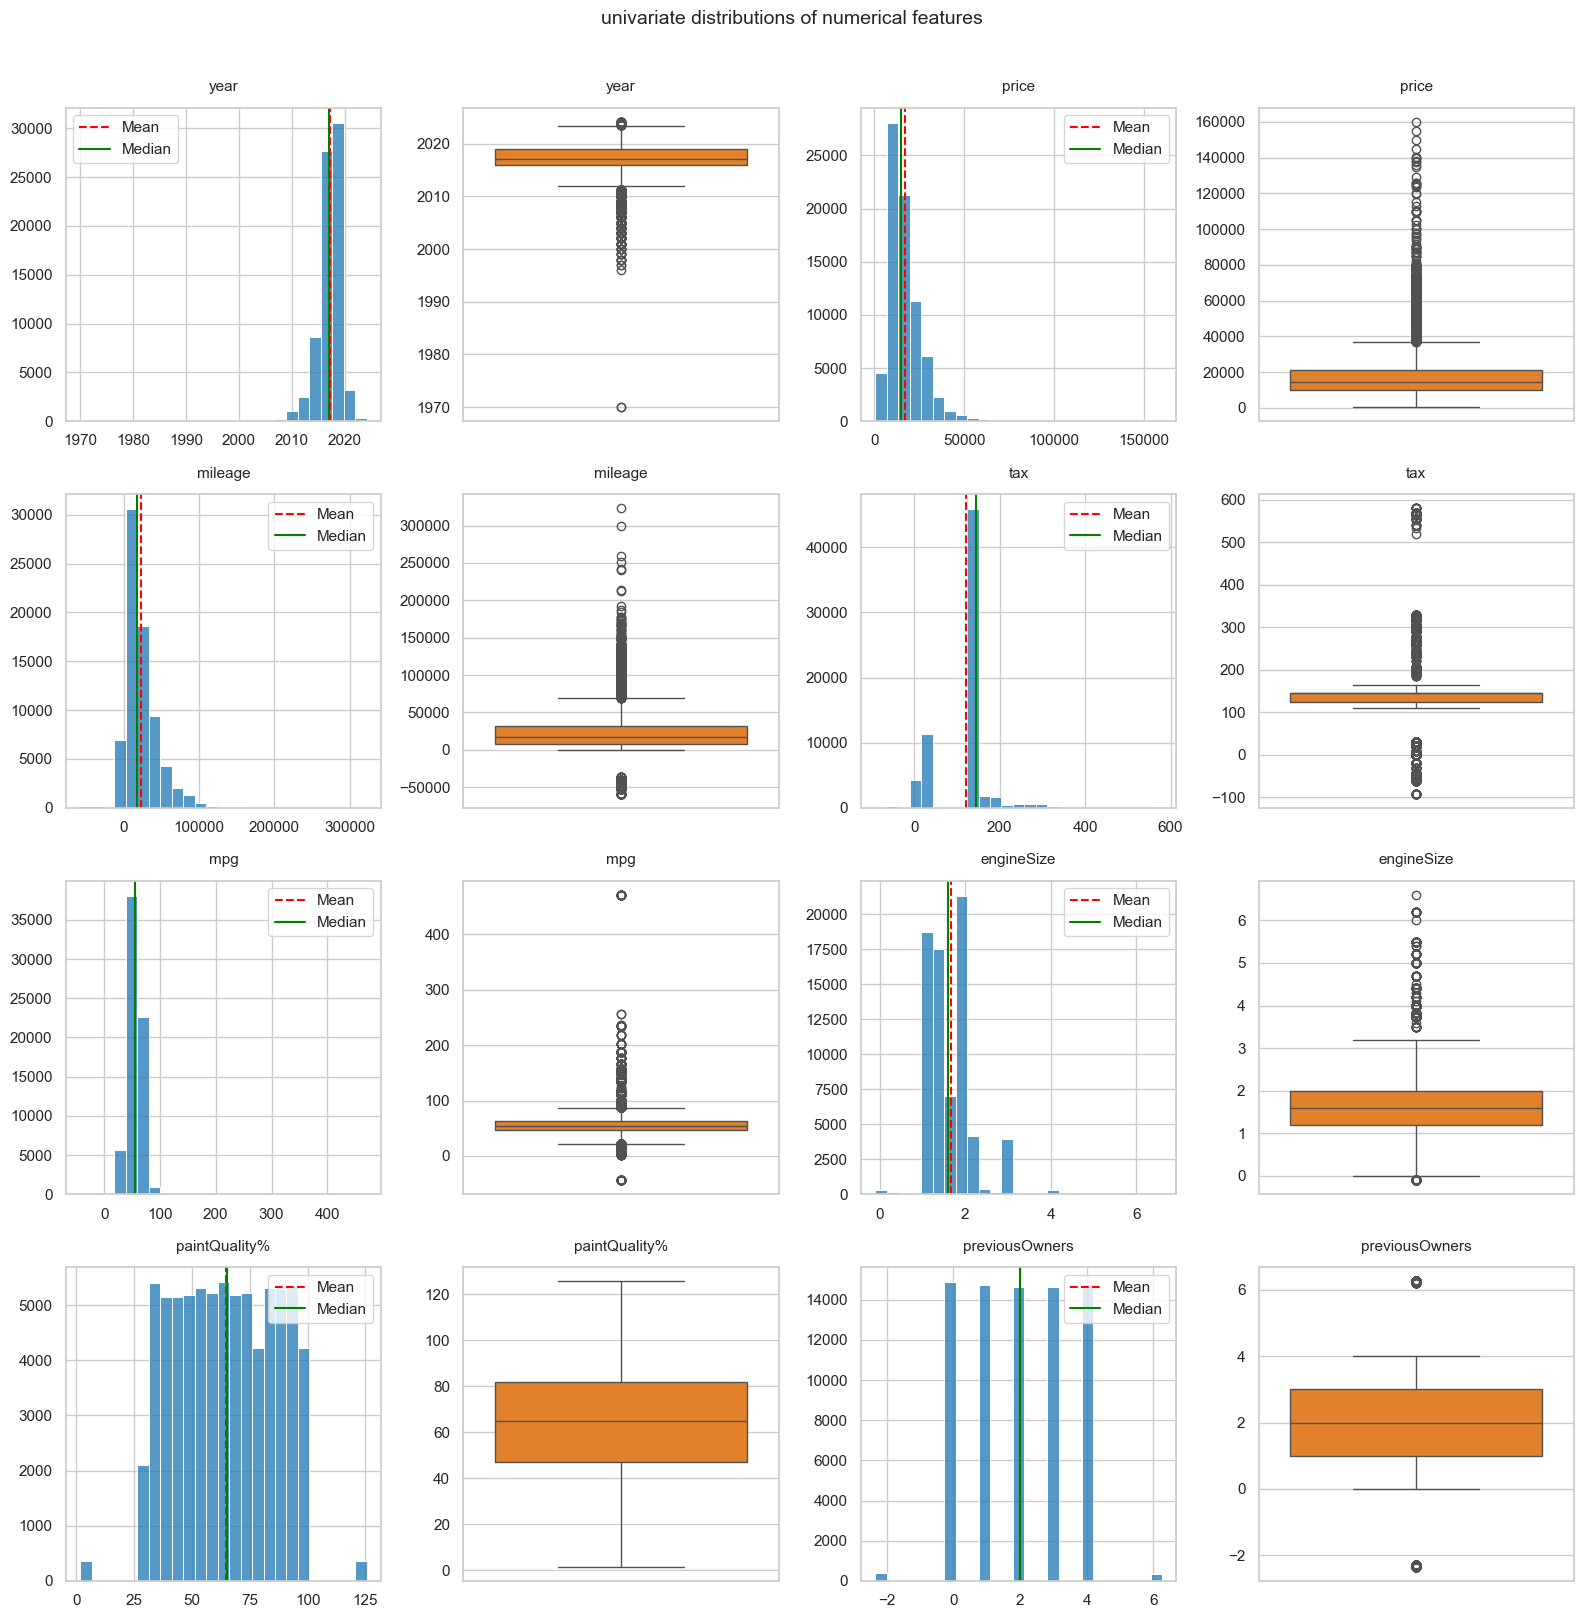

In [12]:
plot_numerical_univariate_distributions(df_cars_train, num_cols)

In [13]:
# Analyze the gap in paintQuality
print(df_cars_train['paintQuality%'].unique())
display(df_cars_train[df_cars_train['paintQuality%'] < 4].sort_values('paintQuality%'))
display(df_cars_train[df_cars_train['paintQuality%'] >= 4].sort_values('paintQuality%'))
df_cars_train[df_cars_train['paintQuality%'].between(4, 29)]
print("==> Remove paintQuality values below 5 and above 100 as outliers in data cleaning step. These values are not just outliers but also stored as float values which is inconsistent with the other values.")

[ 63.          50.          56.          97.          74.
  75.          59.          85.          35.          68.
  45.          30.          69.          53.          57.
  40.          60.          94.          33.          51.
  47.          87.          61.          83.          95.
  46.          54.          80.          77.          90.
  91.          71.          44.          38.          64.
  55.          66.          82.          41.          81.
  79.          72.          34.          88.                  nan
  43.          31.          32.          96.          84.
  70.          86.          92.          52.          39.
  42.          73.          78.          37.          65.
  93.          89.          99.          36.          62.
 125.10995148   3.1152953   67.         125.5694986   76.
  48.           3.17268306  49.           3.25476013 125.59430832
  98.          58.           3.20741784 125.4535988    3.14037046
   1.76947364   3.22574362 125.30194543 125.2020

carID    brand     model    year  price transmission  mileage fuelType  \
30493  54495    toyot      aygo  2018.0   9395       manual   3758.0   petrol   
55179  52380   toyota     yaris  2017.0   9988       manual  15054.0   petrol   
15701  54564   toyota     yaris  2016.0  10998          NaN  17669.0   petrol   
13954  54629   toyota      aygo  2015.0   6291       manual   8539.0   petrol   
25694  54163   toyota     yaris  2016.0  13590    automatic  14964.0   hybrid   
...      ...      ...       ...     ...    ...          ...      ...      ...   
18924  31639  hyundai  santa fe  2017.0  17500       manual  30131.0   diesel   
16467  31436  hyundai       i20  2018.0   9490       manual   4222.0   petrol   
60802  32573  hyundai      ix35  2011.0   6975       manual  60000.0   diesel   
41006  32678  hyundai    tucson  2018.0  15815    automatic  27855.0   diesel   
38747  32552  hyundai    tucson  2016.0  12998       manual  23793.0   diesel   

         tax   mpg  engineSize  paintQuality%  previousOwners  hasDamage  
30493  145.0  56.5    1.000000       1.638913             3.0        0.0  
55179  150.0  56.5    1.500000       1.638913             3.0        0.0  
15701   30.0  55.0    0.162866       1.638913             0.0        0.0  
13954    0.0  69.0    1.000000       1.638913             1.0        0.0  
25694    0.0  78.0    1.500000       1.638913             2.0        0.0  
...      ...   ...         ...            ...             ...        ...  
18924  150.0  47.1    2.200000       3.254760             0.0        0.0  
16467  145.0  46.3    1.200000       3.254760             4.0        0.0  
60802  145.0  48.7    1.700000       3.254760             3.0        0.0  
41006  145.0  47.1    2.000000       3.254760             3.0        0.0  
38747   30.0  61.7    1.700000       3.254760             0.0        0.0  

[359 rows x 14 columns]

carID     brand    model         year  price transmission  mileage  \
33548  18341      ford     kuga  2017.000000  14990       manual  31598.0   
15917  66988        vw     polo  2017.000000  12495    automatic  30892.0   
54788  15635      ford    focus  2010.676968   6800       manual  20600.0   
29209  17792      ford   fiesta  2018.000000  10460       manual  26368.0   
12121  45456  mercedes  b class  2017.000000  12699    semi-auto  31633.0   
...      ...       ...      ...          ...    ...          ...      ...   
52247  54616    toyota    auris  2014.000000  14895    automatic  23102.0   
17041  52430    toyota    auris  2017.000000  10490    automatic  35000.0   
75610  53222    toyota    auris  2014.000000  12675    automatic  20011.0   
61464  52499    toyota    yaris  2018.000000  10995        anual  10601.0   
22881  54677    toyota    yaris  2014.000000   5499       manual  66575.0   

      fuelType    tax   mpg  engineSize  paintQuality%  previousOwners  \
33548   diesel  150.0  60.1         2.0      30.000000             4.0   
15917    other  145.0  60.1         1.2      30.000000             0.0   
54788   petrol    NaN   NaN         1.6      30.000000             0.0   
29209   petrol  145.0  65.7         1.0      30.000000             3.0   
12121   diesel    NaN  70.6         1.5      30.000000             2.0   
...        ...    ...   ...         ...            ...             ...   
52247   hybrid    0.0  70.6         1.8     125.594308             3.0   
17041   petrol    NaN  61.4         1.2     125.594308             1.0   
75610   hybrid    0.0  72.4         1.8     125.594308             1.0   
61464   petrol  145.0  58.9         1.5     125.594308             2.0   
22881   petrol  125.0  52.3         1.3     125.594308             2.0   

       hasDamage  
33548        0.0  
15917        0.0  
54788        0.0  
29209        0.0  
12121        0.0  
...          ...  
52247        0.0  
17041        0.0  
75610        0.0  
61464        0.0  
22881        0.0  

[74090 rows x 14 columns]

==> Remove paintQuality values below 5 and above 100 as outliers in data cleaning step. These values are not just outliers but also stored as float values which is inconsistent with the other values.


## 4.2 Categorical

In [14]:
# plot_univariate_distributions(cat_cols)
def plot_categorical_distributions(df, cols):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    top_n = 20

    for ax, col in zip(axes, cols):
        vc = df[col].value_counts().nlargest(top_n)
        sns.barplot(x=vc.index, y=vc.values, color=hist_color, ax=ax)
        ax.set_title(f'{col}')
        ax.set_xlabel('')
        ax.set_ylabel('count')
        ax.tick_params(axis='x', rotation=90)
        ax.set_xticklabels(ax.get_xticklabels(), ha='right')

    # hide any unused axes (in case cat_cols length < axes)
    for i in range(len(cat_cols), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

Top 20 most frequent values per categorical column:


/var/folders/st/wy1z6qp53p5dffwzq_jkt4pw0000gn/T/ipykernel_50501/108479373.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/var/folders/st/wy1z6qp53p5dffwzq_jkt4pw0000gn/T/ipykernel_50501/108479373.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/var/folders/st/wy1z6qp53p5dffwzq_jkt4pw0000gn/T/ipykernel_50501/108479373.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/var/folders/st/wy1z6qp53p5dffwzq_jkt4pw0000gn/T/ipykernel_50501/108479373.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoca

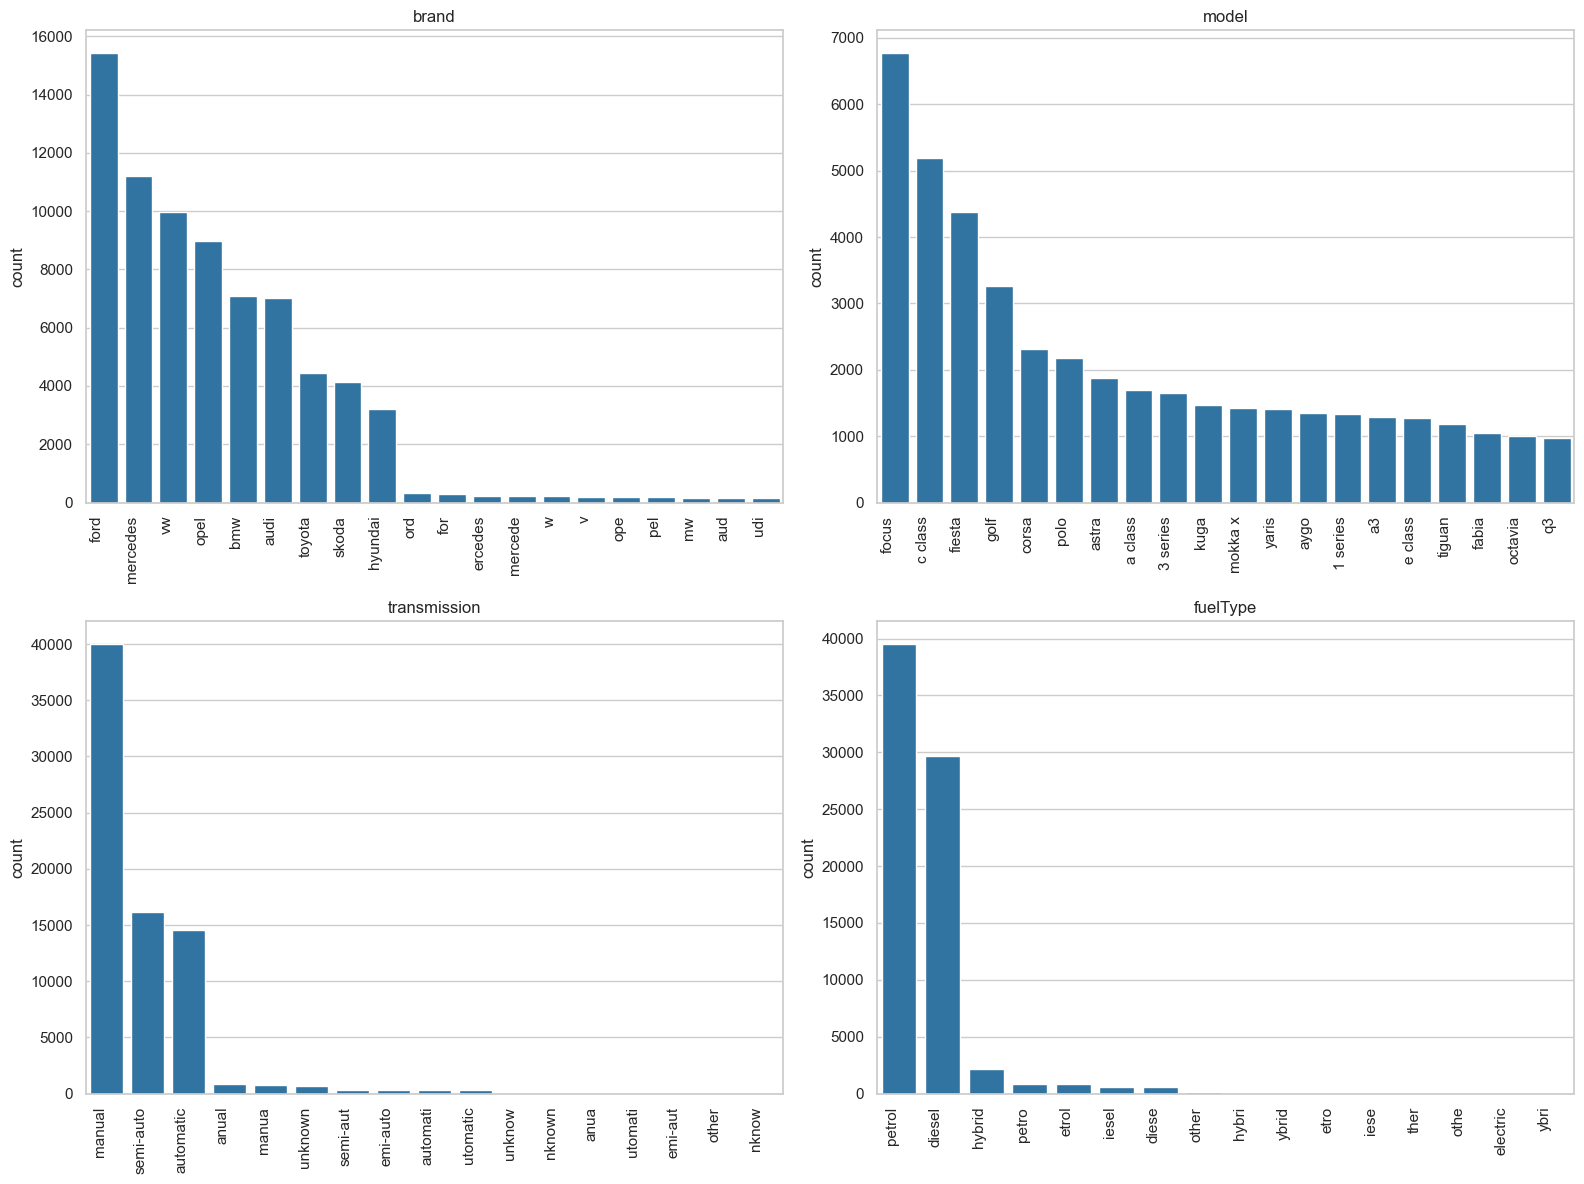

In [15]:
print("Top 20 most frequent values per categorical column:")
plot_categorical_distributions(df_cars_train, cat_cols)

In [16]:
df_cars_train['brand'].value_counts()

brand
ford        15431
mercedes    11209
vw           9973
opel         8979
bmw          7102
audi         7028
toyota       4455
skoda        4138
hyundai      3201
ord           320
for           305
ercedes       236
mercede       222
w             208
v             204
ope           188
pel           181
mw            149
aud           147
udi           147
bm            141
oyota          93
koda           82
skod           81
toyot          74
yundai         68
hyunda         64
or              7
ercede          7
pe              4
yunda           3
ud              3
kod             2
Name: count, dtype: int64

In [17]:
df_cars_train['model'].value_counts()

model
focus             6775
c class           5194
fiesta            4384
golf              3261
corsa             2319
                  ... 
tiguan allspac       1
8 serie              1
230                  1
fox                  1
terracan             1
Name: count, Length: 296, dtype: int64

In [18]:
df_cars_train['transmission'].value_counts()

transmission
manual       40026
semi-auto    16178
automatic    14574
anual          817
manua          772
unknown        704
semi-aut       347
emi-auto       342
automati       316
utomatic       315
unknow          18
nknown          13
anua            12
utomati          6
emi-aut          5
other            5
nknow            1
Name: count, dtype: int64

In [19]:
df_cars_train['fuelType'].value_counts()

fuelType
petrol      39536
diesel      29655
hybrid       2139
petro         817
etrol         810
iesel         619
diese         600
other         155
hybri          45
ybrid          40
etro           18
iese           11
ther            6
othe            6
electric        4
ybri            1
Name: count, dtype: int64

## 4.3 Findings after Descriptive Statistics and Inconsistency Check

<div class="alert alert-info">
    <b>Attention:</b> The target variable (price) is right-skewed -> requires log-transform for linear models.
</div>

<div class="alert alert-warning">
    <b>Warning:</b> Some <b>numerical features</b> (mileage, tax, mpg, engineSize, previousOwner) contain negative entries, which is not possible. Data cleaning is necessary to ensure a more accurate analysis.
</div>

<div class="alert alert-warning">
    <b>Warning:</b> All <b>categorical features</b> (brand, model, transmission and fuelType) contain numerous spelling inconsistencies. Data cleaning is necessary to ensure accurate and interpretable results.
</div>

**Numerical:**

price (Target variable):  
- range **£450–£159,999**, mean ≈ **£16.9k**, median ≈ **£14.7k** → right-skewed (log-transform useful before building a linear regression model)  
- typical cars priced **£10k–£21k**, few luxury outliers inflate mean  
- consistent integer values, no missing or obvious anomalies  
- strong dependence expected on **mileage**, **year**, **engine size**, and **brand**

carID:  
- sequential numeric identifier, ranges from **0–75,972**  
- no duplicates expected, used only as index/key  

year:  
- values range from **1970–2024**, mean ≈ **2017**  
- years after **2020** are unrealistic (future registration) → invalid entries  
- Two cars in year **1970** are outliers with a big gap to the following cars (starting from 1996)
- decimals in year (e.g. **2023.367**) → data corruption, round to nearest int  
- older outliers before **2000** rare, likely classic or miscoded entries  
- can derive **age = 2020 - year** for modeling  

mileage:  
- range **–58,540 → 323,000** → negatives invalid  
- mean ≈ **23k** < median ≈ **17k** → right-skewed
- missing values around **1.5k**  
- strong right skew, some extreme outliers >**250k miles**  
- negative or zero values should be filtered or replaced with abs()  

tax:  
- range **–91 → 580**, mean ≈ **120** → invalid negatives present  
- normal values cluster around **125–145**  
- decimals and small negatives appear due to calculation/entry errors  
- likely strong right skew → a few cars taxed over **500**  
- needs capping and replacement for negatives  

mpg:  
- range **–43 → 470**, mean ≈ **55** → negative and extreme outliers exist  
- typical real range **30–70 mpg**, but some values like **470** unrealistic  
- invalid entries indicate unit mix-up or input noise  
- expected inverse relation with **engine size** and **price**  

engineSize:  
- range **–0.1 → 6.6L**, mean ≈ **1.66L**, std ≈ **0.57**  
- several decimals and negative/zero values → invalid  
- expected valid range **0.6–6.0L**  
- most cars between **1.2–2.0L** → compact to mid-size engines  

paintQuality%:  
- range **1.6 → 125.6%**, mean ≈ **64.6%**  
- values above **100%** unrealistic → scaling error  
- some extremely low values (**≈1–3%**) indicate outliers or noise  
- most cars between **50–80%** → average paint quality  
- **No values between 4 and 29** → Remove values < 5 and > 100 because they are not only outliers but also stored as float values which is inconsistent with the other values suggesting wrong data entry.

previousOwners:  
- range **–2.3 → 6.26**, mean ≈ **2**  
- negative values invalid → likely placeholder or encoding issue  
- most between **0–3** → typical secondhand ownership distribution  
- outliers >**6** likely data entry errors or mis-scaling  

hasDamage:  
- only values are **0 and NaN** → no variation  
- unclear if NaN means damaged → convert to int and verify meaning  
- likely nonfunctional feature → **drop**  


**Categorical:**

brand:  
- **72 unique brands** with severe spelling and capitalization inconsistencies (**Ford**, **ford**, **FOR**, **ord**, **For**, etc.)  
- contains partial or truncated names (**w**, **MW**, **Ope**, **Mercede**) → heavy cleaning required  
- **Ford dominates (~15k entries)**, followed by **BMW**, **VW**, **Mercedes**, **Toyota**, **Audi**, **Skoda**, **Hyundai**  
- strong class imbalance → use frequency encoding or median price per brand later  

model:  
- **735 unique entries** with inconsistent formatting, spacing, capitalization, and partial strings  
- duplicates of same model under variations (e.g. *“focus”*, *“ FOCUS”*, *“ Focu”*, *“Focus”*)  
- many small typos, truncated or malformed entries (*“Focu”*, *“EcoSpor”*, *“Gol”*, *“Yeti Outdoo”*, etc.)  
- heavy normalization needed → strip whitespace, lowercase, and fix common truncations  
- dominated by popular models like **Ford Focus**, **VW Golf**, **Vauxhall Astra/Corsa**, **Skoda Octavia**  

transmission:  
- **40 distinct entries**, mostly spelling variants of *manual*, *automatic*, *semi-auto*  
- common corruptions: *manua*, *anual*, *semi-aut*, *utomatic*, *nknow*, etc.  
- some leading/trailing spaces (*' manual '*, *' Manual '*)  
- categories should be reduced to clean labels: **manual**, **automatic**, **semi-auto**, **unknown**

fuelType:
- lots of spelling errors
- should be limited to petrol, diesel, hybrid and electric

</div>


# 5. Univariate after data cleaning

In [20]:
print(f"NaN entries because of year < 1886 and > 2020: {len(df_cars_train[df_cars_train['year'] < 1886])} and {len(df_cars_train[df_cars_train['year'] > 2020])}\n")

print(f"NaN entries because of mileage < 0: {len(df_cars_train[df_cars_train['mileage'] < 0])}. Of those already NaN because of year: {len(df_cars_train[(df_cars_train['mileage'] < 0) & ((df_cars_train['year'] < 1886) | (df_cars_train['year'] > 2020))])}\n")

print(f"NaN entries because of tax < 0: {len(df_cars_train[df_cars_train['tax'] < 0])}. Of those already NaN because of year: {len(df_cars_train[(df_cars_train['tax'] < 0) & ((df_cars_train['year'] < 1886) | (df_cars_train['year'] > 2020))])}. Of those already NaN because of mileage: {len(df_cars_train[(df_cars_train['tax'] < 0) & (df_cars_train['mileage'] < 0)])}\n")

print(f"NaN entries because of mpg < 5 and > 150: {len(df_cars_train[df_cars_train['mpg'] < 5])} and {len(df_cars_train[df_cars_train['mpg'] > 150])}. Of those already NaN because of year: {len(df_cars_train[((df_cars_train['mpg'] < 5) | (df_cars_train['mpg'] > 150)) & ((df_cars_train['year'] < 1886) | (df_cars_train['year'] > 2020))])}. Of those already NaN because of mileage: {len(df_cars_train[(df_cars_train['mpg'] < 5) & (df_cars_train['mileage'] < 0)]) + len(df_cars_train[(df_cars_train['mpg'] > 150) & (df_cars_train['mileage'] < 0)])}. Because of tax: {len(df_cars_train[(df_cars_train['mpg'] < 5) & (df_cars_train['tax'] < 0)]) + len(df_cars_train[(df_cars_train['mpg'] > 150) & (df_cars_train['tax'] < 0)])}\n")

print(f"NaN entries because of engineSize < 0.1 and > 12.7 : {len(df_cars_train[df_cars_train['engineSize'] < 0.1])} and {len(df_cars_train[df_cars_train['engineSize'] > 12.7])}. Of those already NaN because of year: {len(df_cars_train[((df_cars_train['engineSize'] < 0.1) | (df_cars_train['engineSize'] > 12.7)) & ((df_cars_train['year'] < 1886) | (df_cars_train['year'] > 2020))])}. Of those already NaN because of mileage: {len(df_cars_train[(df_cars_train['engineSize'] < 0.1) & (df_cars_train['mileage'] < 0)]) + len(df_cars_train[(df_cars_train['engineSize'] > 12.7) & (df_cars_train['mileage'] < 0)])}. Because of tax: {len(df_cars_train[(df_cars_train['engineSize'] < 0.1) & (df_cars_train['tax'] < 0)]) + len(df_cars_train[(df_cars_train['engineSize'] > 12.7) & (df_cars_train['tax'] < 0)])}. Because of mpg: {len(df_cars_train[(df_cars_train['engineSize'] < 0.1) & ((df_cars_train['mpg'] < 5) | (df_cars_train['mpg'] > 150))]) + len(df_cars_train[(df_cars_train['engineSize'] > 12.7) & ((df_cars_train['mpg'] < 5) | (df_cars_train['mpg'] > 150))])}\n")

print(f"Nan entries because of paintQuality < 0 and > 100: {len(df_cars_train[df_cars_train['paintQuality%'] < 0])} and {len(df_cars_train[df_cars_train['paintQuality%'] > 100])}. Of those already NaN because of year: {len(df_cars_train[((df_cars_train['paintQuality%'] < 0) | (df_cars_train['paintQuality%'] > 100)) & ((df_cars_train['year'] < 1886) | (df_cars_train['year'] > 2020))])}. Of those already NaN because of mileage: {len(df_cars_train[((df_cars_train['paintQuality%'] < 0) | (df_cars_train['paintQuality%'] > 100)) & (df_cars_train['mileage'] < 0)])}. Because of tax: {len(df_cars_train[((df_cars_train['paintQuality%'] < 0) | (df_cars_train['paintQuality%'] > 100)) & (df_cars_train['tax'] < 0)])}. Because of mpg: {len(df_cars_train[((df_cars_train['paintQuality%'] < 0) | (df_cars_train['paintQuality%'] > 100)) & ((df_cars_train['mpg'] < 5) | (df_cars_train['mpg'] > 150))])}. Because of engineSize: {len(df_cars_train[((df_cars_train['paintQuality%'] < 0) | (df_cars_train['paintQuality%'] > 100)) & ((df_cars_train['engineSize'] < 0.1) | (df_cars_train['engineSize'] > 12.7))])}\n")

print(f"Nan entries because of previousOwners < 0 : {len(df_cars_train[df_cars_train['previousOwners'] < 0])}. Of those already NaN because of year: {len(df_cars_train[(df_cars_train['previousOwners'] < 0) & ((df_cars_train['year'] < 1886) | (df_cars_train['year'] > 2020))])}. Of those already NaN because of mileage: {len(df_cars_train[(df_cars_train['previousOwners'] < 0) & (df_cars_train['mileage'] < 0)])}. Because of tax: {len(df_cars_train[(df_cars_train['previousOwners'] < 0) & (df_cars_train['tax'] < 0)])}. Because of mpg: {len(df_cars_train[(df_cars_train['previousOwners'] < 0) & ((df_cars_train['mpg'] < 5) | (df_cars_train['mpg'] > 150))])}. Because of engineSize: {len(df_cars_train[(df_cars_train['previousOwners'] < 0) & ((df_cars_train['engineSize'] < 0.1) | (df_cars_train['engineSize'] > 12.7))])}. Because of paintQuality: {len(df_cars_train[(df_cars_train['previousOwners'] < 0) & ((df_cars_train['paintQuality%'] < 0) | (df_cars_train['paintQuality%'] > 100))])}")

print("\n ==> Barely any overlaps between NaN entries of different columns.")


NaN entries because of year < 1886 and > 2020: 0 and 358

NaN entries because of mileage < 0: 369. Of those already NaN because of year: 1

NaN entries because of tax < 0: 378. Of those already NaN because of year: 2. Of those already NaN because of mileage: 2

NaN entries because of mpg < 5 and > 150: 49 and 221. Of those already NaN because of year: 0. Of those already NaN because of mileage: 4. Because of tax: 1

NaN entries because of engineSize < 0.1 and > 12.7 : 264 and 0. Of those already NaN because of year: 1. Of those already NaN because of mileage: 0. Because of tax: 0. Because of mpg: 22

Nan entries because of paintQuality < 0 and > 100: 0 and 367. Of those already NaN because of year: 4. Of those already NaN because of mileage: 1. Because of tax: 4. Because of mpg: 0. Because of engineSize: 1

Nan entries because of previousOwners < 0 : 371. Of those already NaN because of year: 3. Of those already NaN because of mileage: 4. Because of tax: 4. Because of mpg: 1. Because o

In [21]:
print(f"Number of rows without missing values: {df_cars_train.dropna(inplace=False).shape[0]}")
print(f"Length of dataset before cleaning: {len(df_cars_train)}")

cleaner = CarDataCleaner(handle_electric="other", set_carid_index=False)
df_cars_train_cleaned = cleaner.fit_transform(df_cars_train)

print(f"\nNumber of rows without missing values after cleaning: {df_cars_train_cleaned.dropna(inplace=False).shape[0]}")
print(f"Length of dataset after cleaning: {len(df_cars_train_cleaned)}")

print("\n==> These NaNs will be handled during preprocessing in the pipeline.")

Number of rows without missing values: 54449
Length of dataset before cleaning: 75973

Number of rows without missing values after cleaning: 54396
Length of dataset after cleaning: 75973

==> These NaNs will be handled during preprocessing in the pipeline.


## 5.1 Numerical

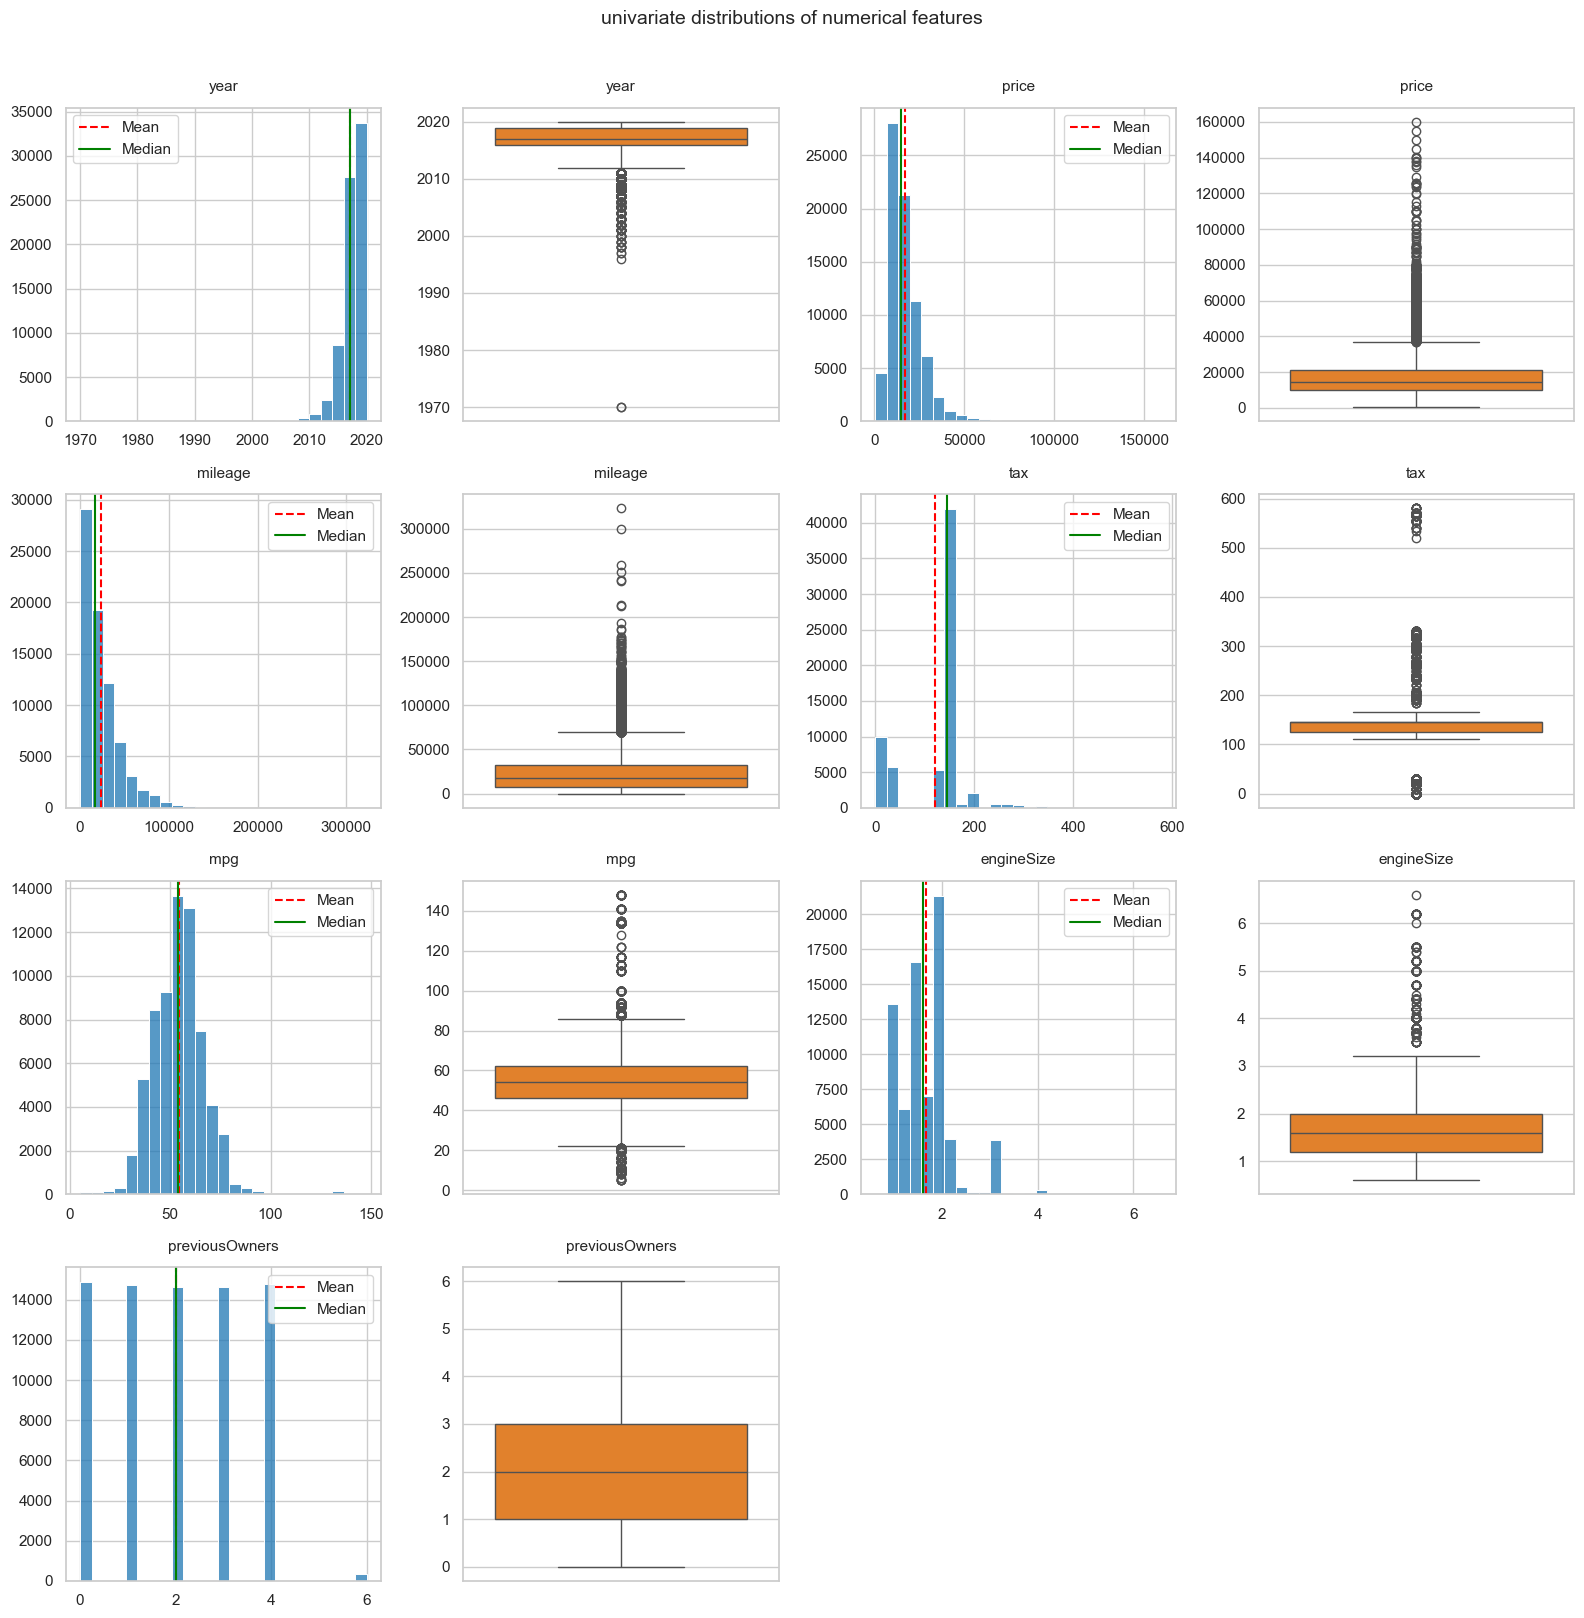

In [22]:
num_cols = [col for col in num_cols if col != "paintQuality%"] # paintQuality gets dropped in CarDataCleaner because it is filled by mechanic and we cant use it.
plot_numerical_univariate_distributions(df_cars_train_cleaned, num_cols)

## 5.2 Categorical

/var/folders/st/wy1z6qp53p5dffwzq_jkt4pw0000gn/T/ipykernel_50501/108479373.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/var/folders/st/wy1z6qp53p5dffwzq_jkt4pw0000gn/T/ipykernel_50501/108479373.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/var/folders/st/wy1z6qp53p5dffwzq_jkt4pw0000gn/T/ipykernel_50501/108479373.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='right')
/var/folders/st/wy1z6qp53p5dffwzq_jkt4pw0000gn/T/ipykernel_50501/108479373.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoca

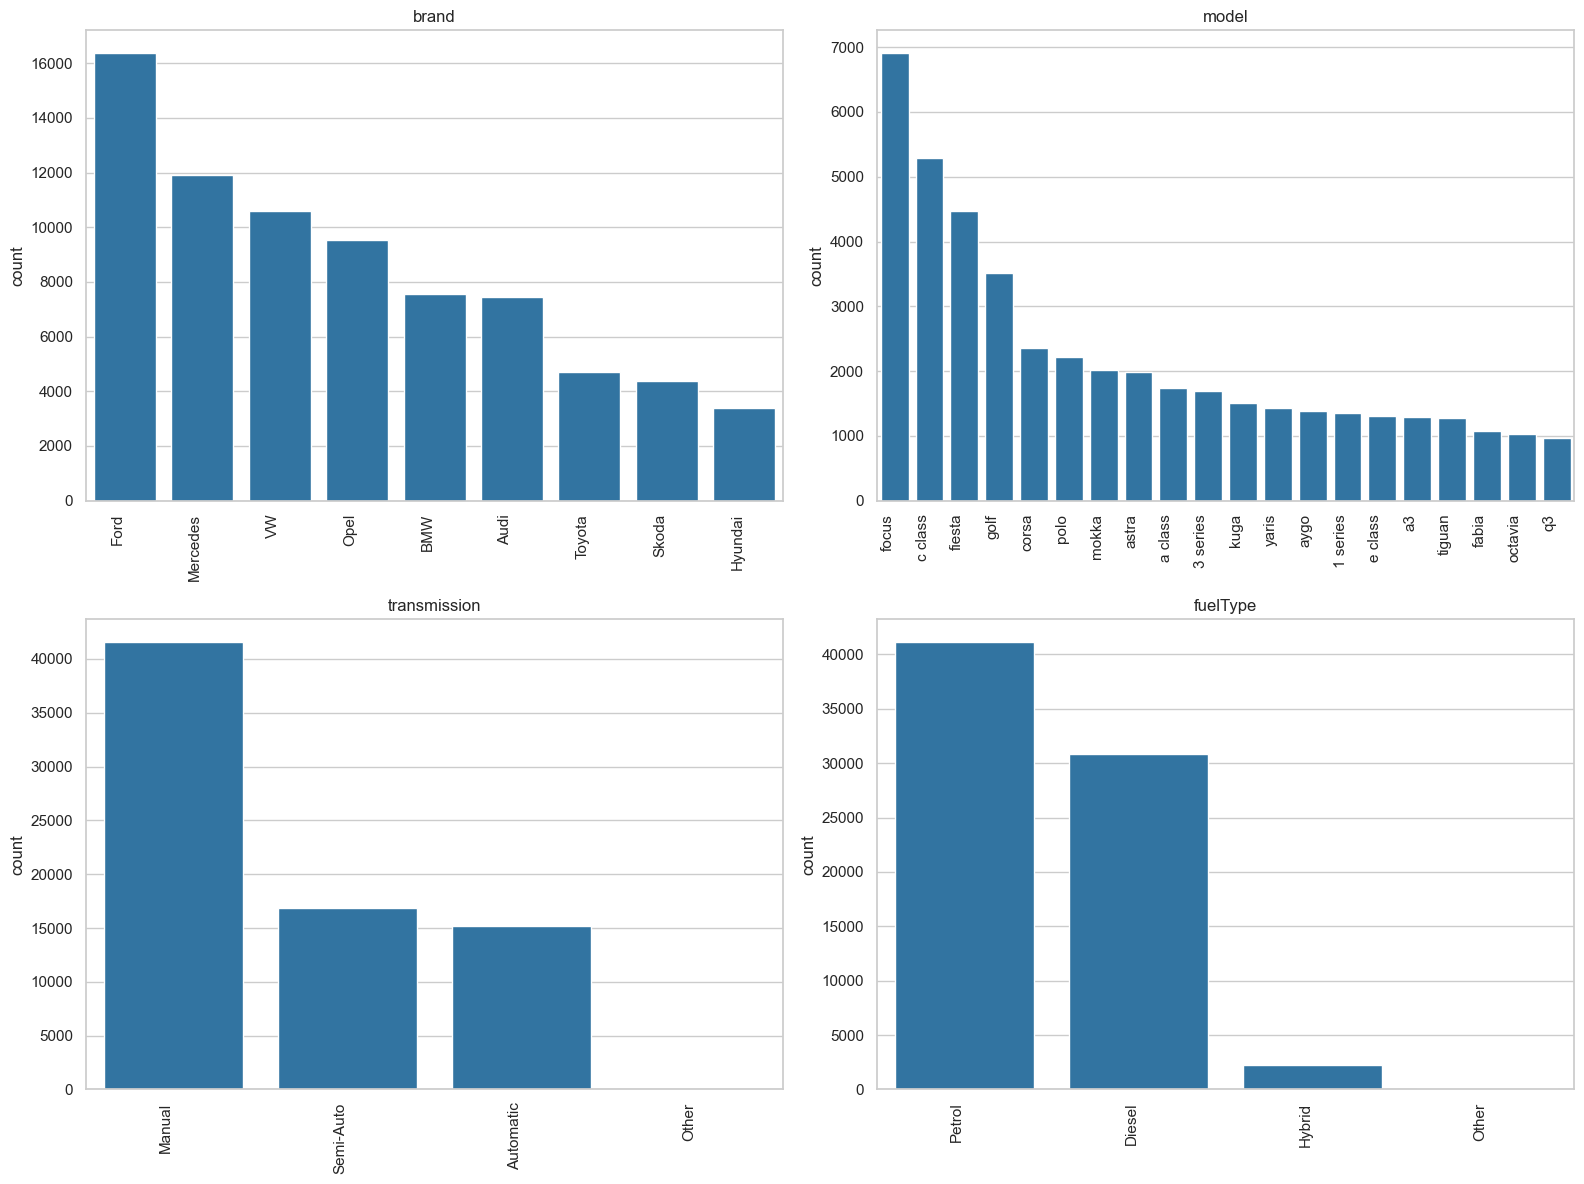

In [23]:
plot_categorical_distributions(df_cars_train_cleaned, cat_cols)

In [24]:
df_cars_train_cleaned['brand'].value_counts(dropna=False)

brand
Ford        16386
Mercedes    11904
VW          10603
Opel         9539
BMW          7542
Audi         7460
Toyota       4716
Skoda        4382
Hyundai      3401
NaN            40
Name: count, dtype: int64

In [25]:
print(df_cars_train_cleaned['model'].value_counts(dropna=False))
print(f"NaNs: {df_cars_train_cleaned['model'].isna().sum()}")

model
focus       6915
c class     5288
fiesta      4470
golf        3515
corsa       2359
            ... 
ranger         1
accent         1
a2             1
veloster       1
terracan       1
Name: count, Length: 184, dtype: int64
NaNs: 1542


In [26]:
df_cars_train_cleaned['transmission'].value_counts(dropna=False)

transmission
Manual       41615
Semi-Auto    16867
Automatic    15205
NaN           2281
Other            5
Name: count, dtype: int64

In [27]:
df_cars_train_cleaned['fuelType'].value_counts(dropna=False)

fuelType
Petrol    41181
Diesel    30885
Hybrid     2225
NaN        1511
Other       171
Name: count, dtype: int64

## 5.3 New Findings after cleaning

**Numerical**:

paintQuality:
- ranges from 0-100 now without the (probably invalid) outliers
- roughly equally distributed

mpg:
- After the cleaning, the distribution looks very **symmetric** with a roughly mean=median=54

other numerical features:
- Except for that, no notable new findings, just cleaner distributions without the invalid negative values (mileage, tax, mpg, engineSize, previousOwner).
----


**Categorical:**

brand:
- **Only 9 unique brands** left after cleaning the strings
- from 3400 (Hyundai) to ~16.000 (Ford) entries
- **108 NaNs** that will be imputed in preprocessing

model:
- **Only 114 unique models** left after cleaning the strings
- **4 cars** with **over 3500 entries** dominate the dataset (focus, c class, fiesta, golf)
- **5121 NaNs** that will be imputed in preprocessing

transmission:
- **Most** of the cars are **Manual** (41615/75973)
- **Semi-Auto and Automatic** are roughly **equally distributed** (16867 and 15205)
- Some entries are Unknown (735) or marked as Other (5) -> has to be dealt with in preprocessing
- **1546 NaNs** that will be imputed in preprocessing

fuelType:
- Nearly all cars are **Petrol or Diesel** (41181 and 30885)
- Some Hybrids (2225) and **barely no Electrics (4)** -> they now got imputed to "Other" - Reasoning is made in CarDataCleaner
- Some marked as Other (167) -> has to be dealt with in preprocessing
- **1511 NaNs** that will be imputed in preprocessing

# 6. Bivariate Analysis

Bivariate analysis is performed on the cleaned data to ensure a reliable analysis that is not hindered by invalid values.

## 6.1 Numerical-Numerical Associations

### 6.1.1 Pairplot

Pairplots to visualize the relationships before computing metrics like correlation to quantify them.

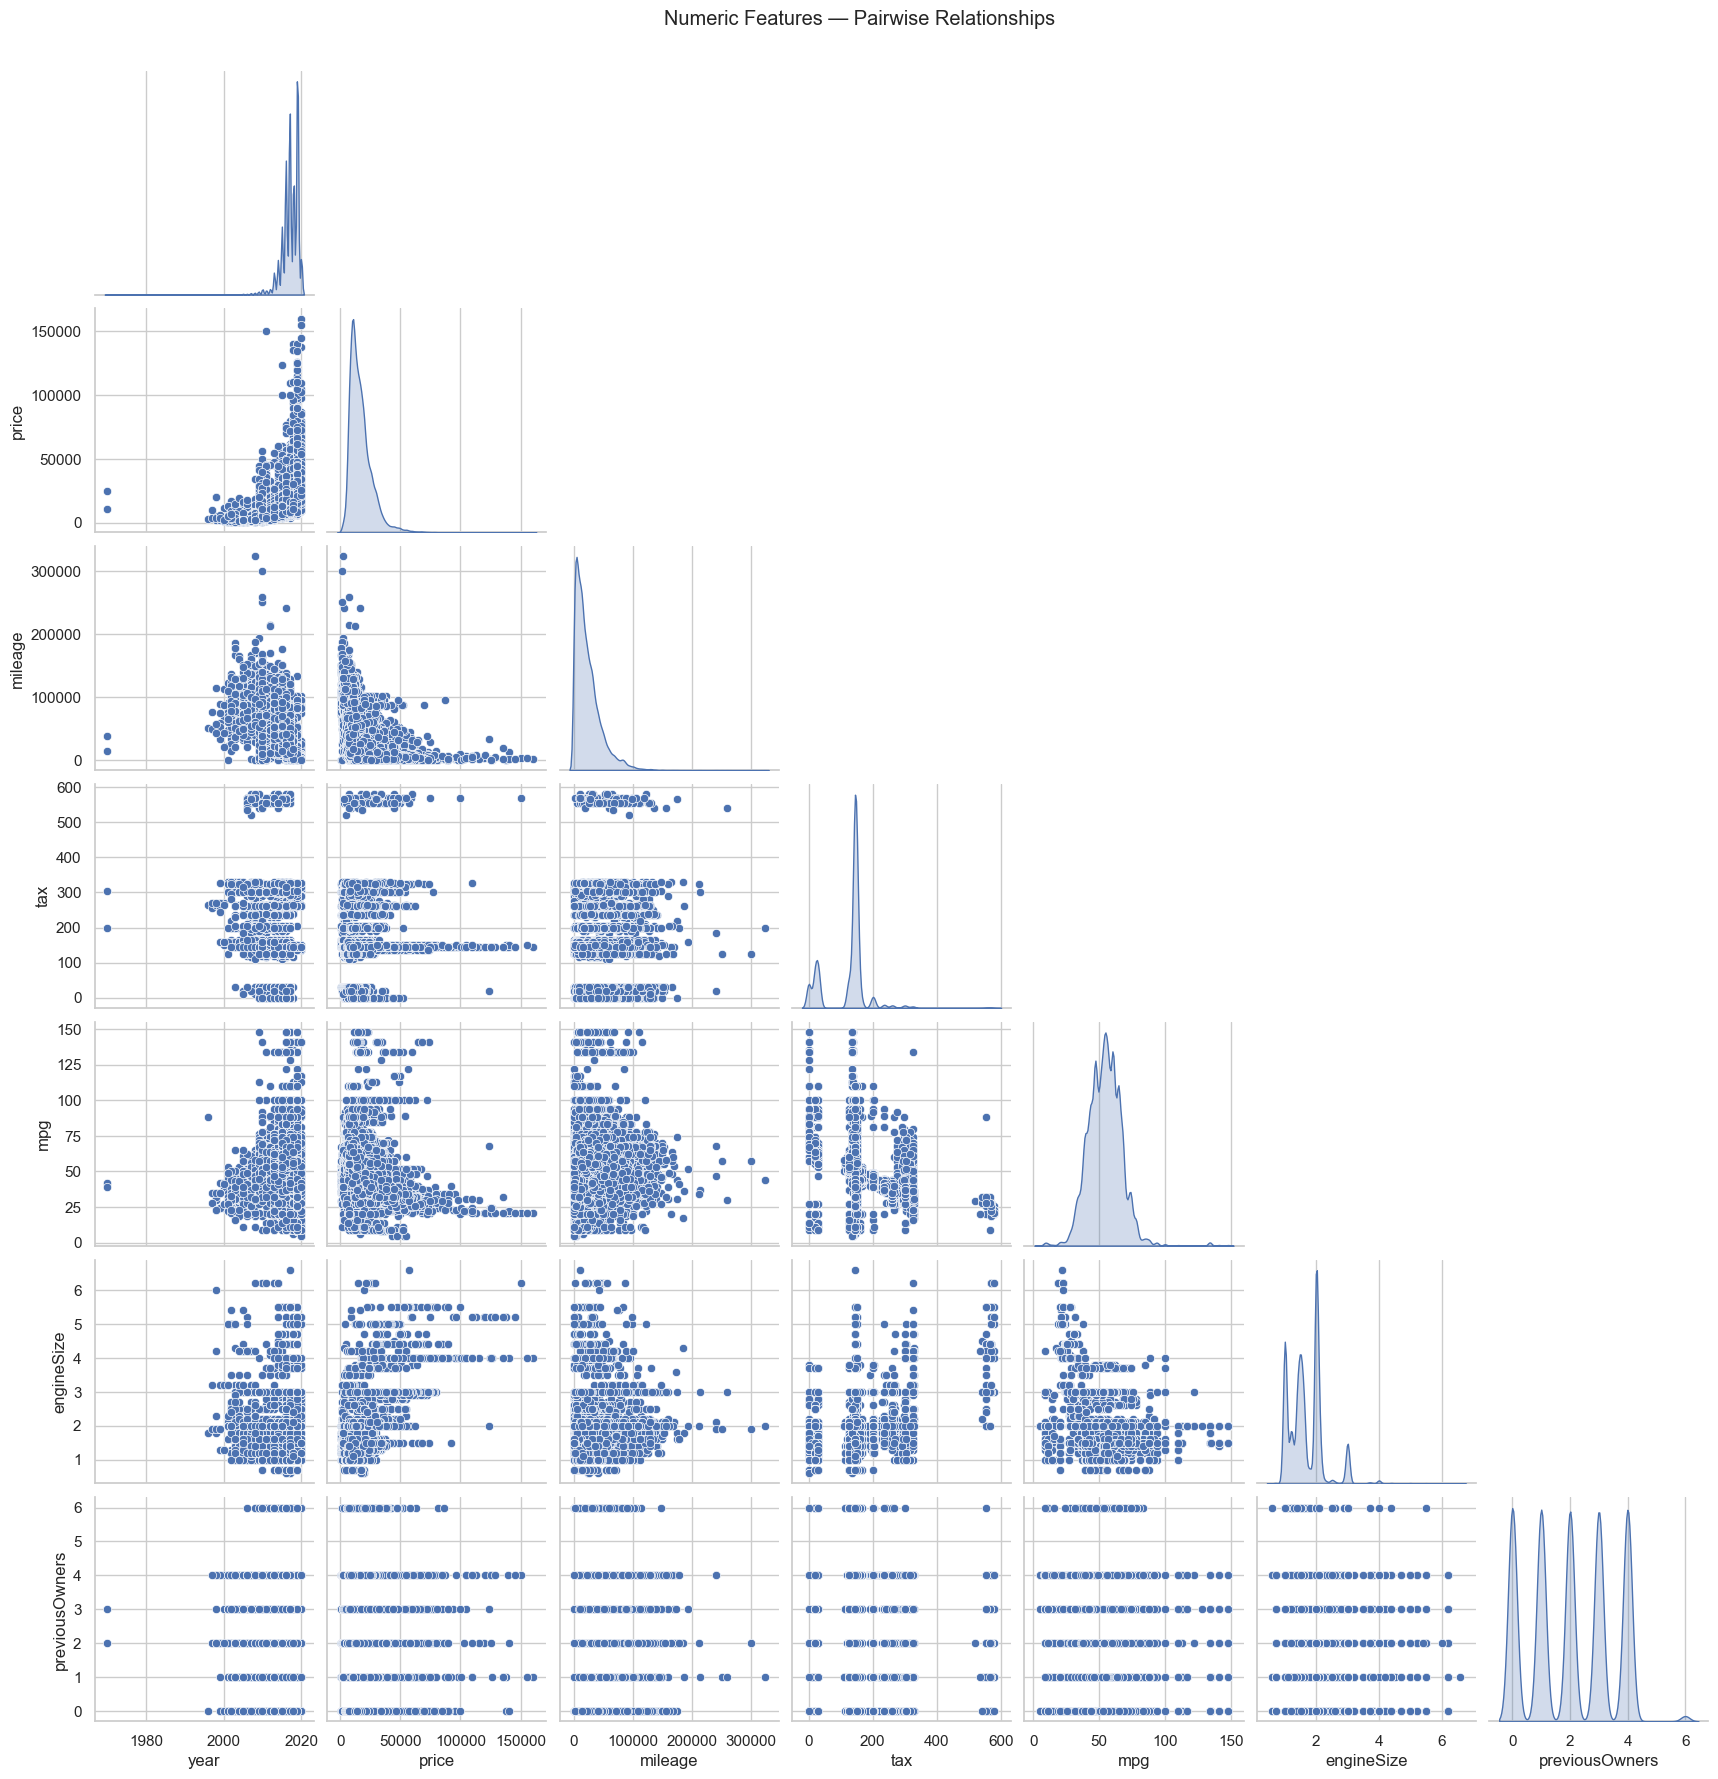

In [28]:
g = sns.pairplot(df_cars_train_cleaned[num_cols], diag_kind='kde', corner=True) # NAs are included because they will be imputed and therefore should be part of the distribution
g.figure.suptitle('Numeric Features — Pairwise Relationships', y=1.02)
plt.show()

<div class="alert alert-info">
    <b>Attention:</b> Heteroscedastic relationships between target (price) and predictors (years, mileage) violate the assumption of linear models → Linear regression models are probably not be the best choice for this dataset (log-transform necessary).
</div>

**Findings** (more details in the Findings Correlation section)

Price (Target variable):
- **Very strong positive and heteroscedastic relationship with years**: The most expensive cars are the newest cars with the spread for new cars being higher than for old cars → Cheap new cars exist while there is no expensive very old car in the data
- **Strong Negative and heteroscedastic relationship with mileage**: As mileage increases, the price decreases. At low mileage, there is a huge range of possible prices. At high mileage, all cars have a low price, and the spread is very small. → Some older cars have been driven long distances, while others have relatively low mileage despite their age
- **Negative and heteroscedastic relationship with mpg**: However, low-mpg cars have a very wide range of prices while high-mpg cars are almost all in the low-price bracket.
- **Strong positive and heteroscedastic relationship with engineSize**: As engineSize increases, price tends to increase. No very expensive cars with very small engine size.
- **Relationship seems to be negative with previousOwners**: Cars with many previous owners are found only in the lowest price bracket.

Relationships between independent variables will be analyzed explicitly in the Correlation Section.

### 6.1.2 Correlation

**Why we decided to use Spearman correlation:**

- the numeric variables (price, mileage, tax, engineSize) are **non-normally distributed and contain outliers**, causing linear measures like pearson to distort correlation strength.  
- **spearman** evaluates **monotonic** relationships based on rank order rather than exact linearity, making it **robust to skewness and outliers**.  
- this allows us to correctly capture the direction and magnitude of real-world trends, such as price decreasing with mileage, even if not perfectly linear.  

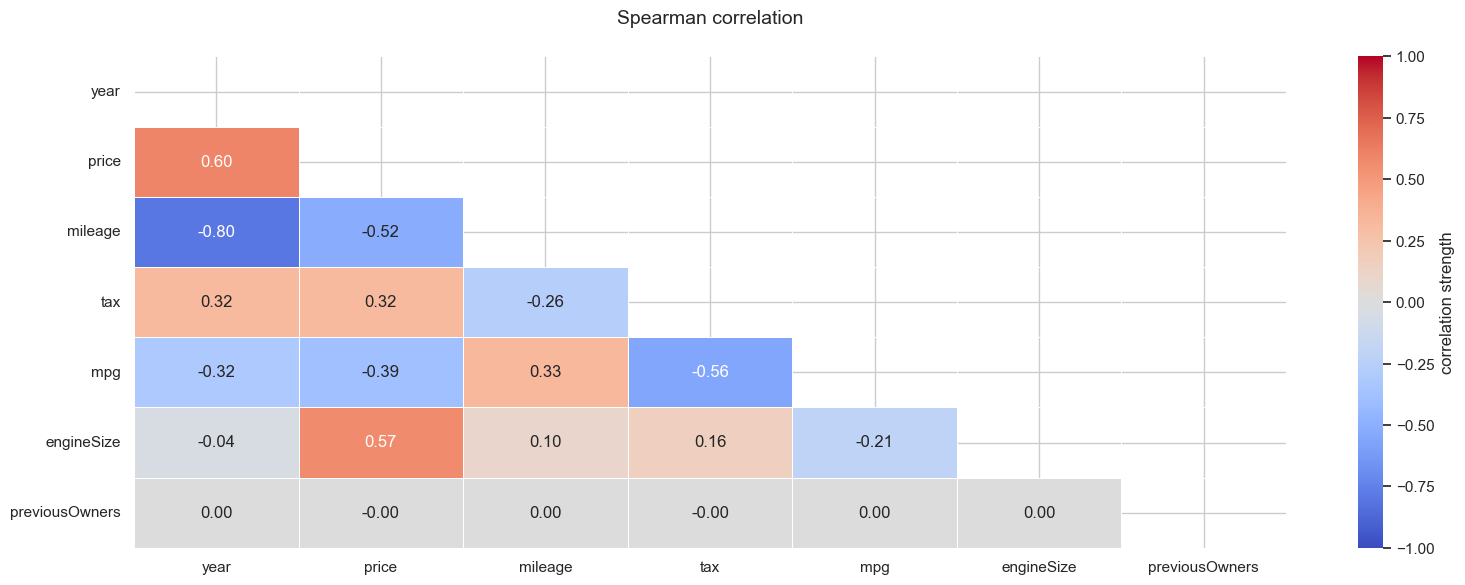

In [29]:
# Calculate spearman correlation
corr_spearman = df_cars_train_cleaned[num_cols].corr(method='spearman', numeric_only=True).round(2)

# Draw the heatmap
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
mask = np.triu(np.ones_like(corr_spearman, dtype=bool))
sns.heatmap(corr_spearman, mask=mask, annot=True, cmap='coolwarm',vmin=-1, vmax=1, center=0, fmt='.2f',
            linewidths=0.5, ax=axes, cbar_kws={'label': 'correlation strength'})

plt.title('Spearman correlation', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

**Findings based on spearman correlation:**

Price (target variable):
- price shows **strong positive correlation with year (0.60)** → newer cars are priced higher  
- price is **positively correlated with engineSize (0.57)** → larger engines increase car value  
- price is **moderately negatively correlated with mileage (–0.52)** → more driven cars lose value  
- price correlates **negatively with mpg (–0.39)** → efficient cars are typically smaller and cheaper  
- tax has a **moderate positive correlation (0.32)** with price → more expensive cars often have higher taxes  

Correlations between independent variables (potential multicollinearity, strong correlation indicates overlapping information about the dependent variable):
- year and mileage have a **very strong negative correlation (–0.79)** → newer cars have lower mileage 
- year has a **moderate positive correlation with tax (0.32)** -> newer cars have higher tax
- year has a **moderate negative correlation with mpg (–0.32)** -> newer cars are more efficient
- mileage is **moderately negatively correlated with tax (-0.26)** -> more driven cars have lower tax
- mileage is **moderately correlated with mpg (0.33)** -> more driven cars are less efficient
- tax and mpg are **strongly negatively correlated (–0.56)** → efficient cars usually taxed less
- mpg and engineSize **correlate negatively (–0.21)** → larger engines are less fuel-efficient  
- **previousOwners** shows **near-zero correlation** with all other variables → low predictive relevance  

=> Overall, **price mainly depends on year, engineSize, mileage, and mpg**, which align with intuitive market behavior

## 6.2 Numerical-Categorical Associations

Use boxplots to see whether numerical features vary depending on the category.

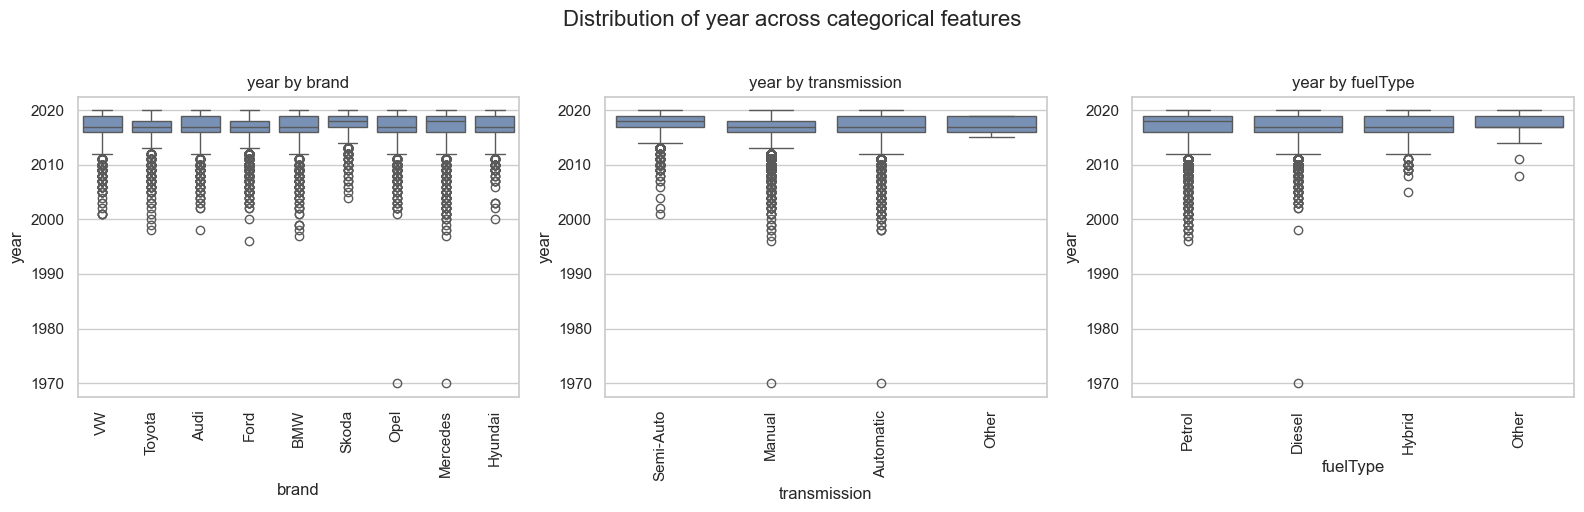

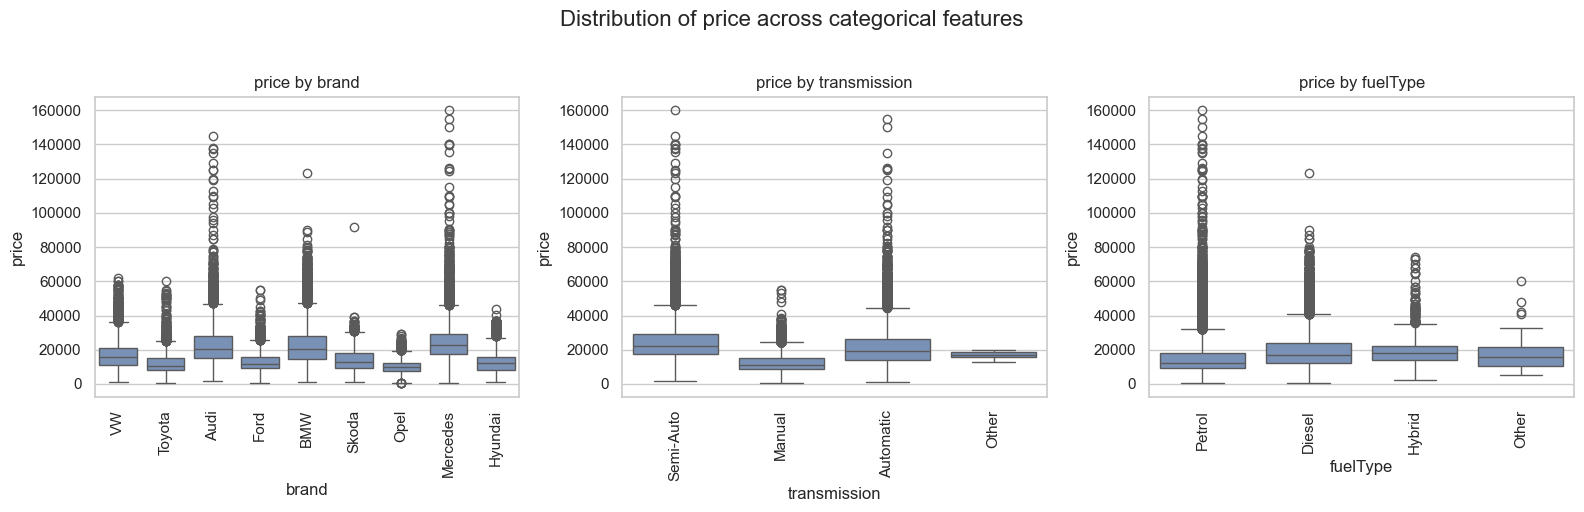

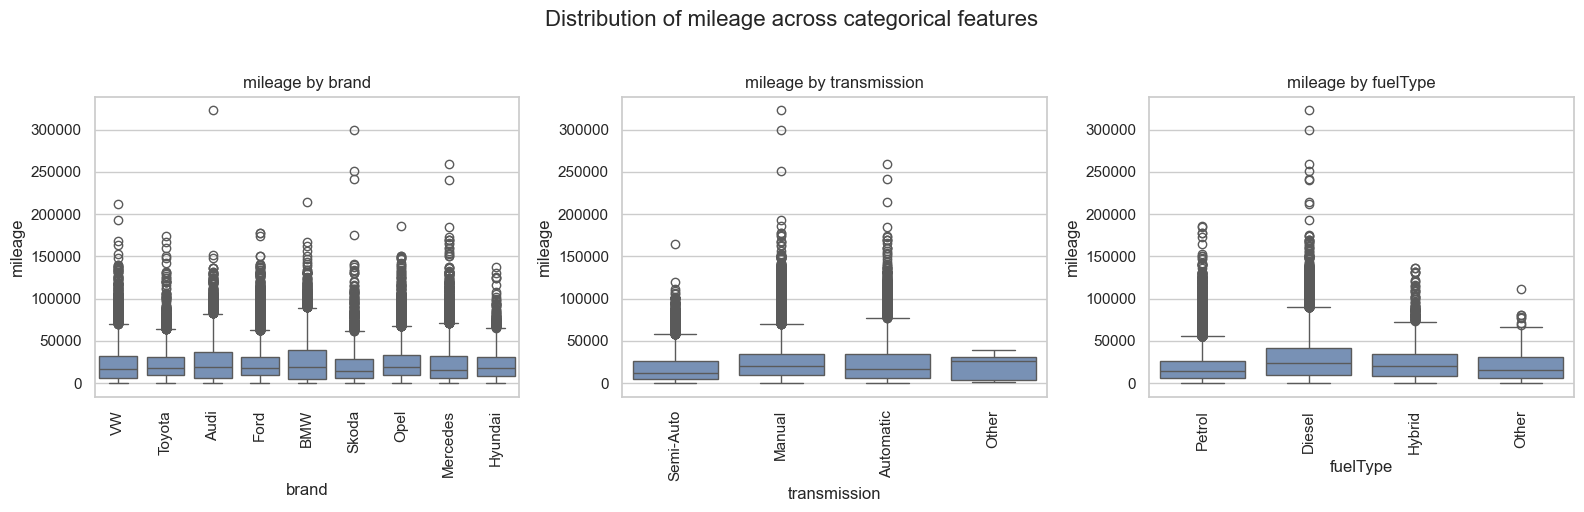

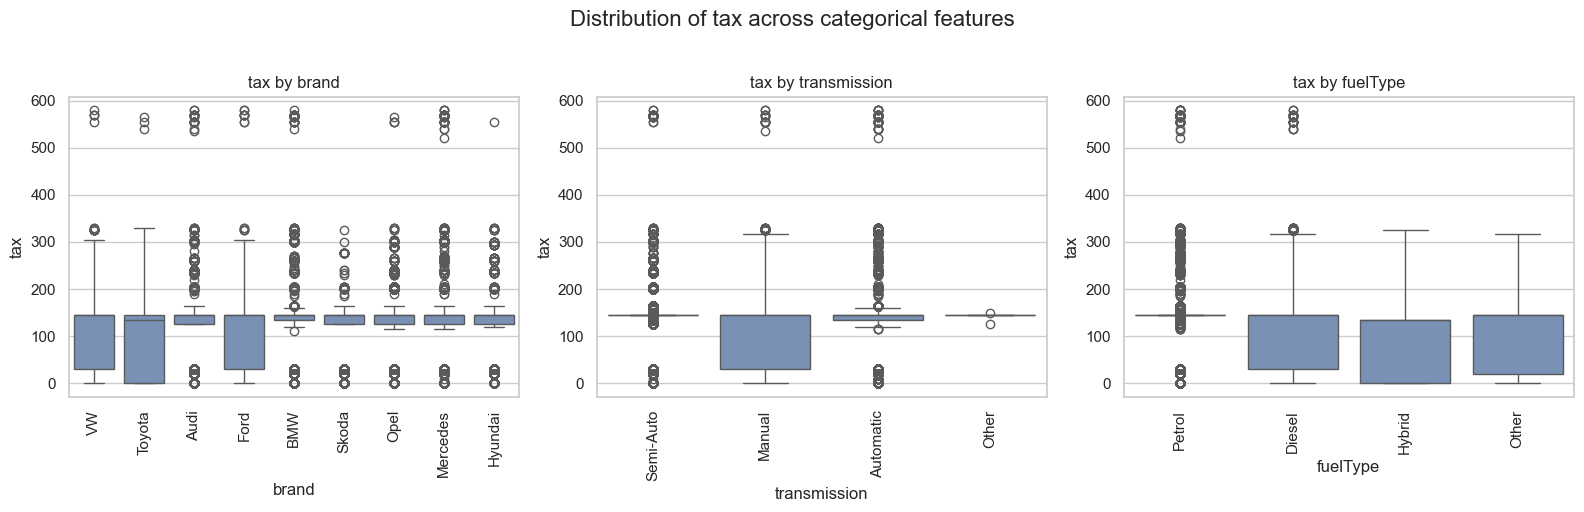

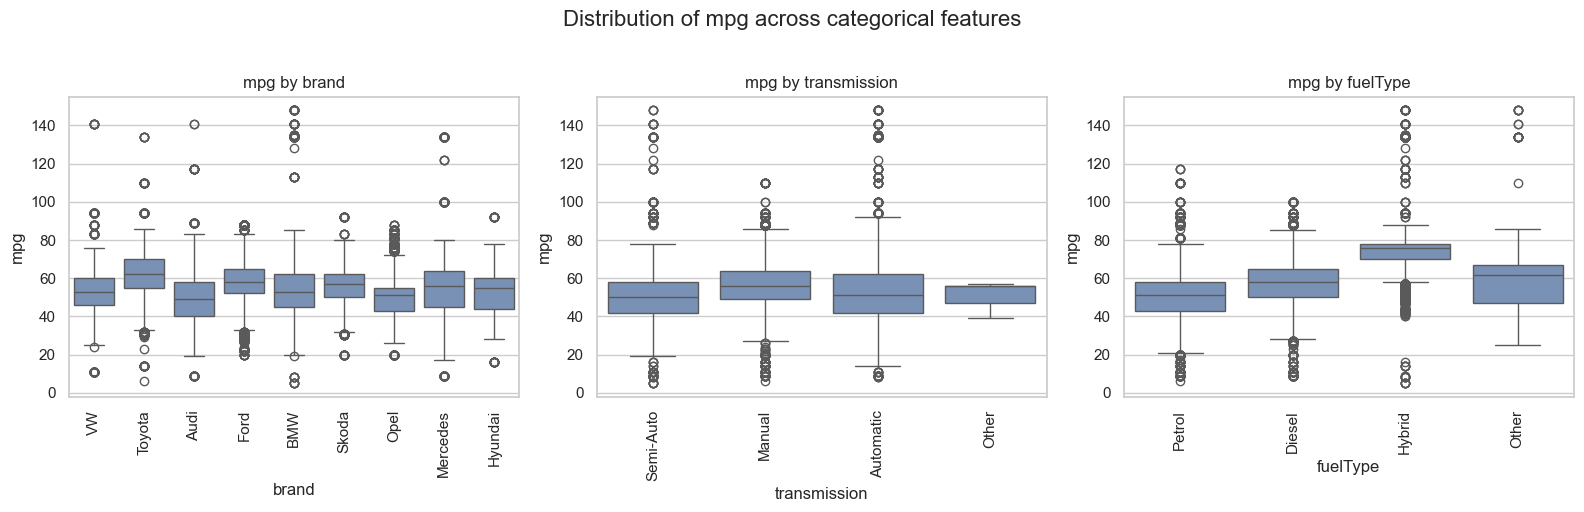

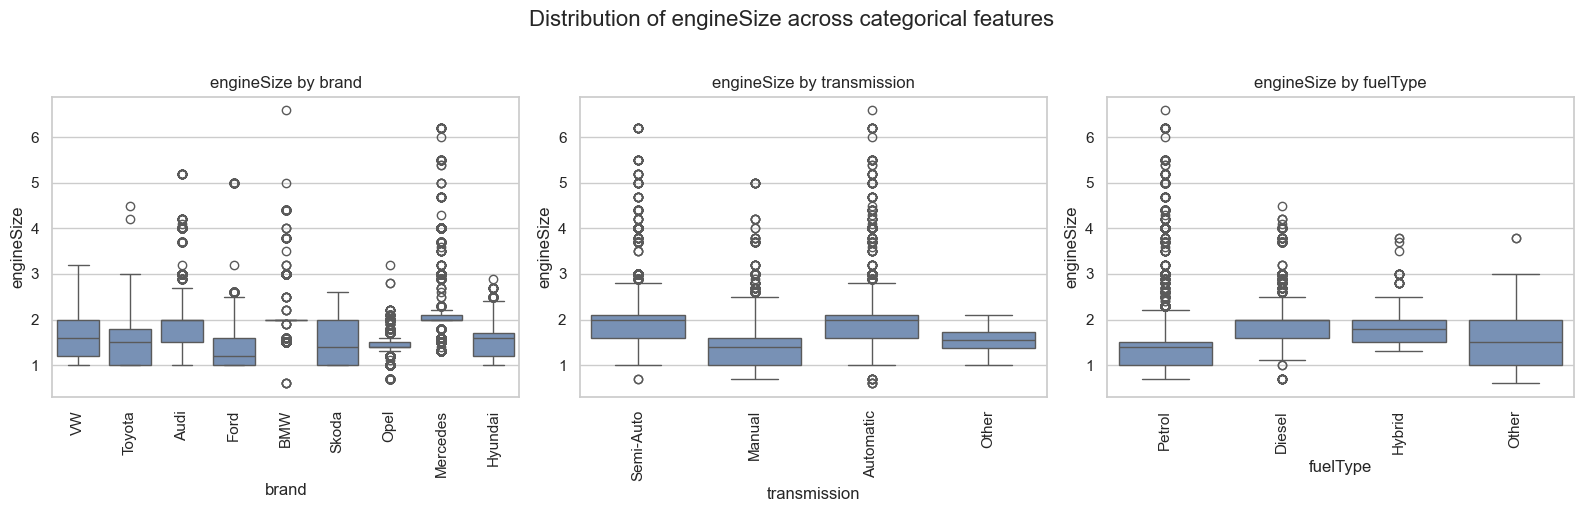

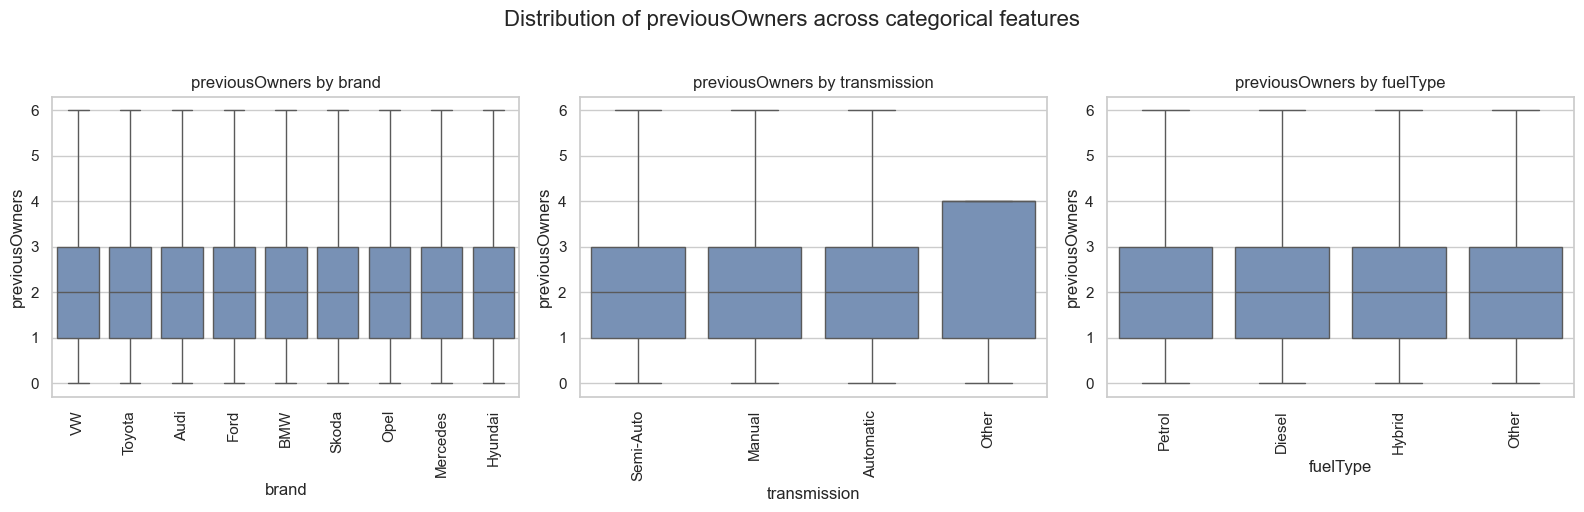

In [30]:
sns.set(style="whitegrid")
sns.set_palette("vlag")

# One figure (grid) per numerical variable in relation to all categorical variables
def plot_categorical_boxplots(num, cat_cols):
    n = len(cat_cols)
    rows = math.ceil(n / 3)
    cols = min(3, n)

    fig, axes = plt.subplots(rows, cols, figsize=(16, 5 * rows))
    axes = axes.flatten()

    for ax, cat in zip(axes, cat_cols):
        sns.boxplot(
            data=df_cars_train_cleaned,
            x=cat,
            y=num,
            ax=ax
        )
        ax.set_title(f"{num} by {cat}")
        ax.tick_params(axis="x", rotation=90)

    # hide any unused axes
    for ax in axes[n:]:
        ax.set_visible(False)

    fig.suptitle(f"Distribution of {num} across categorical features", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

cat_cols_for_bivariate = cat_cols.copy()
cat_cols_for_bivariate.remove('model')  # too many unique values
for num in num_cols:
    plot_categorical_boxplots(num, cat_cols_for_bivariate)

**Findings**

Price (Target variable):
- Audi, BMW and Mercedes are the most expensive brands
- There are no Manual cars with very high prices
- The most expensive cars are petrol cars

Years:
- "Other" transmissions has no old data entry -> could indicate new process for registering transmission
- "Eletric" fuelType has no old data entries -> could indicate new developments in the market

Mileage:
- Highest mileage cars are Diesel cars -> Diesel cars seem to have the longest lifetime

Tax:
- For Hybrid and Electric vehicles are no high taxes recorded -> Either because of lack of enough samples or because they are taxed less than other fuel types

Mpg:
- BMW has multiple outliers with a high mpg -> potentially big cars with low fuel efficiency
- Hybrid cars have higher mpg than petrol or diesel cars -> probably because of electric motor assistance

engineSize:
- varies a lot for BMW and Mercedes -> potentially some cars with high-performance engines and some with standard engines
- the biggest engines are petrol cars

Distribution of previous owners across categorical features don't provide any insights

## 6.3 Categorical-Categorical Associations

Analysis of categorical associations is not immediately important because we don't see the relationship with the numeric target variable (price). However, it is important to understand how the other features relate to each other.

Stacked bar chart to show how one categorical variable is distributed within another → useful to spot **group differences**, **patterns**, and **imbalances** in the data.  
Cramér’s V complements the visuals with a metric.

### 6.3.1 Stacked bar charts

Categorical columns for bivariate analysis: ['brand', 'transmission', 'fuelType']


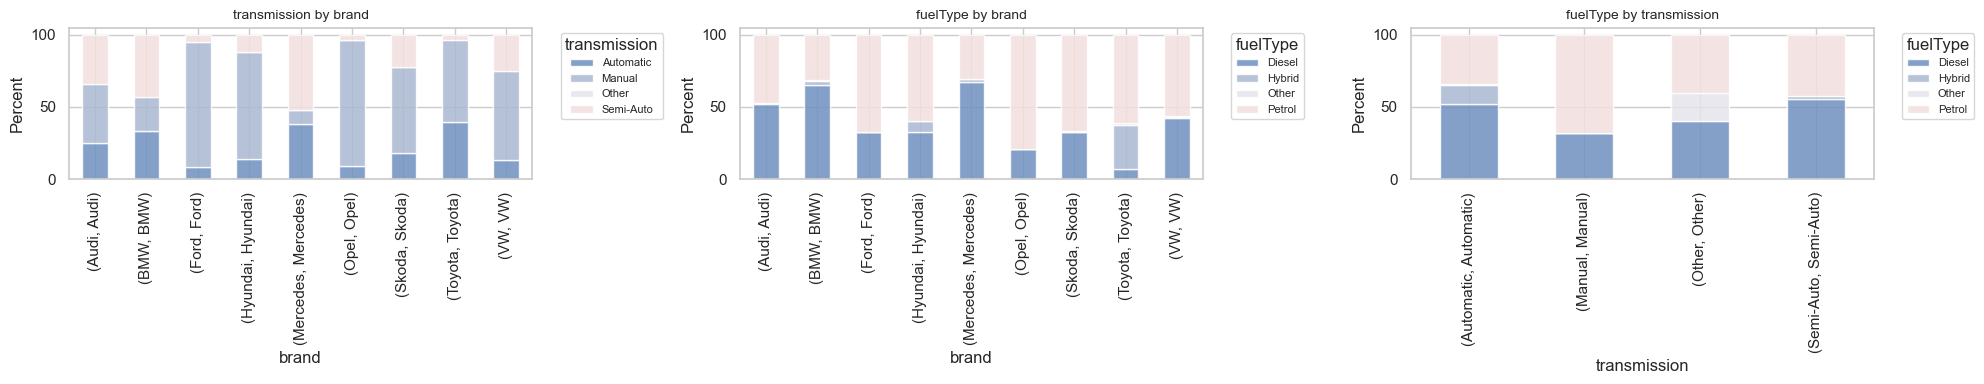

In [31]:
df_cars_train_cleaned_stacked_bars = df_cars_train_cleaned.copy()
print("Categorical columns for bivariate analysis:", cat_cols_for_bivariate)
# Helper to compute %
def stacked_percent(df, g1, g2):
    tmp = df[[g1, g2]].dropna()
    share = (
        tmp.groupby([g1, g2]).size()
        .groupby(level=0).apply(lambda x: x / x.sum() * 100)
        .unstack(fill_value=0)
    )
    return share

pairings = list(combinations(cat_cols_for_bivariate , 2))

# Plot grid
n = len(pairings)
cols = 3
rows = -(-n // cols)  # ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(20, rows*4))
axes = axes.ravel()

sns.set_style("whitegrid")
sns.set_palette("vlag")

for ax, (cat1, cat2) in zip(axes, pairings):
    dist = stacked_percent(df_cars_train_cleaned_stacked_bars, cat1, cat2)
    dist.plot(kind="bar", stacked=True, ax=ax, alpha=0.85)

    ax.set_title(f"{cat2} by {cat1}", fontsize=10)
    ax.set_xlabel(cat1)
    ax.set_ylabel("Percent")
    ax.tick_params(axis="x", rotation=90)
    ax.legend(title=cat2, bbox_to_anchor=(1.05, 1), fontsize=8)

# Hide unused axes if any
for ax in axes[len(pairings):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


**Findings**
- Cars from Ford and Opel are predominantly manual and petrol-fueled -> likely older and more affordable models
- Manual transmission cars are primarily petrol-fueled

### 6.3.2 Cramér's V

**Cramér’s V** is a statistical measure that quantifies how strongly two **categorical variables** are associated: The higher the value, the higher the association.

- It is based on the **Chi-square (χ²) statistic**, which compares the **observed frequencies** in a contingency table to the **expected frequencies** (if the variables were independent).  
- Cramér’s V normalizes this χ² value to produce a result **between 0 and 1**, making it easy to interpret.

\[
V = \sqrt{\frac{\chi^2}{n \times (k - 1)}}
\]

Where:
- **χ²** = Chi-square statistic from the contingency table  
- **n** = total number of observations  
- **k** = smaller of (number of rows, number of columns)

**Key Points**
- Symmetric: same result whether you swap the variables.  
- Works only for **categorical–categorical** relationships.  
- Does **not** tell the *direction* of association (only strength).  

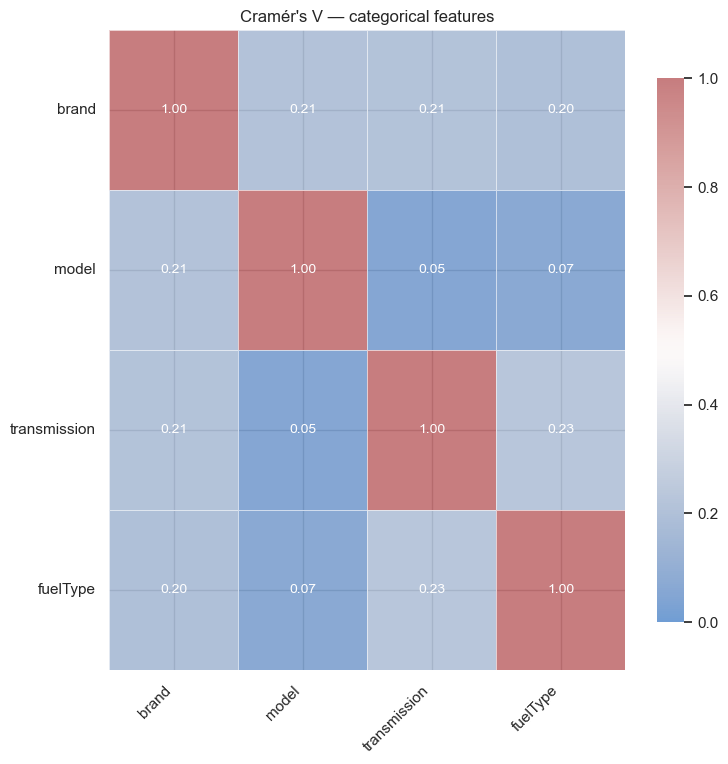

In [32]:
# Cramér's V for categorical features
def cramers_v(x, y):
    tbl = pd.crosstab(x, y)
    if tbl.shape[0] < 2 or tbl.shape[1] < 2:
        return np.nan
    chi2 = chi2_contingency(tbl, correction=False)[0]
    n = tbl.values.sum()
    r, k = tbl.shape
    phi2 = chi2 / n
    # bias correction
    phi2_corr = max(0, phi2 - (k - 1)*(r - 1)/(n - 1))
    r_corr = r - (r - 1)**2/(n - 1)
    k_corr = k - (k - 1)**2/(n - 1)
    denom = max((k_corr - 1), (r_corr - 1))
    return np.sqrt(phi2_corr / denom) if denom > 0 else np.nan

if len(cat_cols) > 1:
    m = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)

    for a in cat_cols:
        for b in cat_cols:
            if a == b:
                m.loc[a, b] = 1.0
            else:
                m.loc[a, b] = cramers_v(df_cars_train_cleaned[a], df_cars_train_cleaned[b])

    plt.figure(figsize=(min(0.7 * len(cat_cols) + 5, 14),
                        min(0.7 * len(cat_cols) + 5, 14)))

    sns.heatmap(
        m.astype(float),
        annot=True,
        fmt=".2f",
        cmap="vlag",
        vmin=0, vmax=1,
        linewidths=.5,
        annot_kws={"size": 10},
        alpha=0.65,
        cbar_kws={"shrink": 0.85}
    )

    plt.title("Cramér's V — categorical features")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough categorical features for Cramér's V.")


**Findings**
- The strongest but still only weak association is between **brand and model** (0.27) which makes sense but the low value suggests that there are many models for each brand, so knowing the brand doesn't perfectly predict the model.

The other associations are too weak and not directly related to our target variable (price) so not worth mentioning.

# 7. Multivariate Analysis

Some 3-dimensional analysis regarding specific relationships with the target variable (price).

## 7.1 price vs. year vs. engineSize

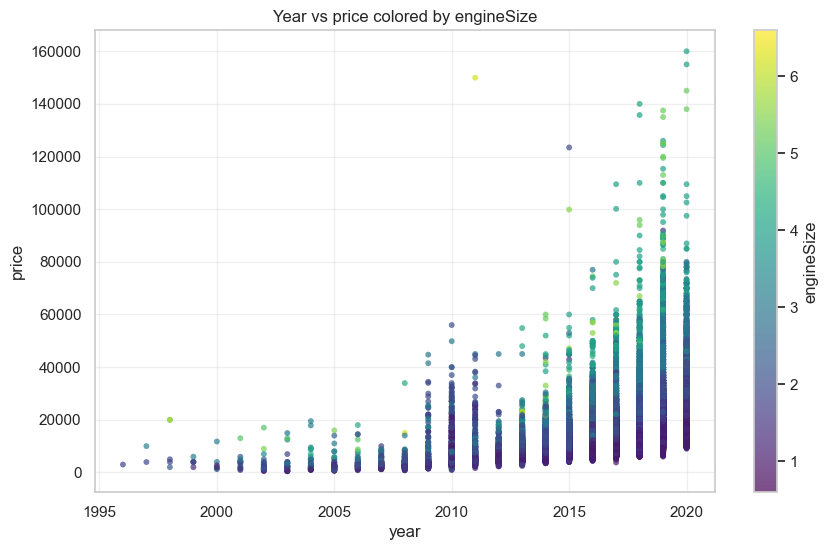

In [33]:
# We already know price goes up with year. This plot will show if that trend is the same for all engine sizes (Scatter plot: x=year, y=price, color=engineSize)
df = df_cars_train_cleaned.copy()
df_plot = df.dropna(subset=['year', 'price', 'engineSize'])

plt.figure(figsize=(10, 6))
sc = plt.scatter(
    df_plot['year'],
    df_plot['price'],
    c=df_plot['engineSize'],
    cmap='viridis',
    s=18,
    alpha=0.7,
    edgecolor='none'
)
cbar = plt.colorbar(sc)
cbar.set_label('engineSize')
plt.xlabel('year')
plt.ylabel('price')
plt.title('Year vs price colored by engineSize')
plt.grid(alpha=0.3)
plt.show()

**Finding:** 
- The year-price line is much steeper for large engineSize (high-performance/luxury cars) than for small engineSize (economy cars) -> interaction effect between year and engineSize -> will be regarded as interaction effect in feature engineering

## 7.2 engineSize vs. mpg vs. price

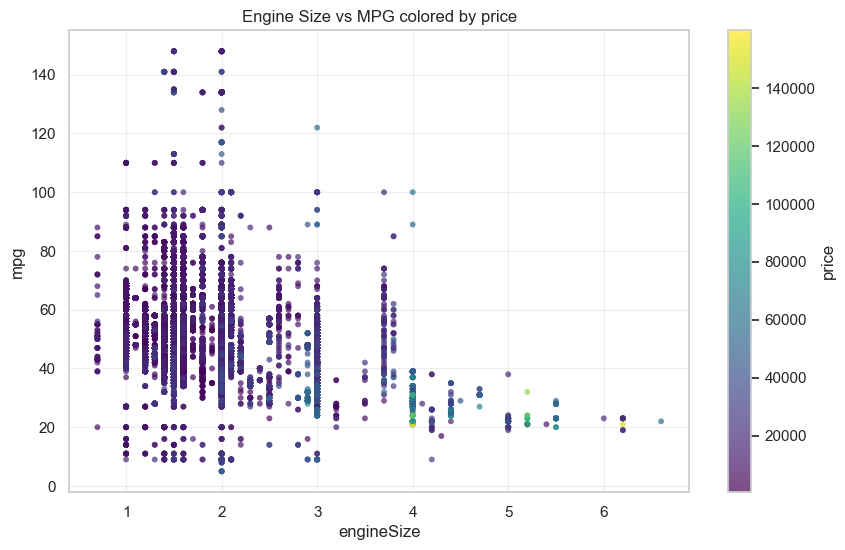

In [34]:
# We already know engineSize and mpg are negatively correlated. By adding price as the color, it checks whether efficient cars are cheaper.
df_plot = df_cars_train_cleaned.copy()
df_plot = df_plot.dropna(subset=['engineSize', 'mpg', 'price']) # scatter: x=engineSize, y=mpg, color=price

plt.figure(figsize=(10, 6))
sc = plt.scatter(
    df_plot['engineSize'],
    df_plot['mpg'],
    c=df_plot['price'],
    cmap='viridis',
    s=18,
    alpha=0.7,
    edgecolor='none'
)
plt.colorbar(sc, label='price')
plt.xlabel('engineSize')
plt.ylabel('mpg')
plt.title('Engine Size vs MPG colored by price')
plt.grid(alpha=0.3)
plt.show()

**Finding:**
- The high price cars (brighter color) are indeed mostly in the "high engineSize / low mpg" corner -> efficient cars are cheaper